# Raspberry Pi Performance Investigation

## Table of Contents
1. [Library Imports](#Library-Imports)  
2. [Initial Helper Functions](#Initial-Helper-Functions)  
3. [File Locations](#File-Locations)  
3. [Deeper Look](#Deeper-Look)
  1. [Raspberry Pi Idle Case](#Raspberry-Pi-Idle-Case)
    1. [CPU](#CPU)
    2. [MEM](#MEM)
  2. [Raspberry Pi Running Program](#Raspberry-Pi-Running-Program)
    1. [CPU](#CPU)
    2. [Memory](#Memory)
  3. [Docker](#Docker)
4. [Comparison of Programs](#Comparison-of-Programs)

## Library Imports

In [1]:
import os.path # Used for isfile()


# For plotting
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib

import numpy as np                      # for arange
from collections import OrderedDict     # For creation of a sorted dictionary
from itertools import zip_longest       # For zipping lists that are of uneven size

In [2]:
# This cell is solely for styling
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['grid.linestyle'] = "-"

Below, I'm making sure that if the data I have is in a zip file, I unzip it. If I already unzipped, I want to assign variable names here.

In [3]:
if (os.path.isdir('../Input/Text')): # First case is that this already exists and I can just use the files within.
    pass
else: # This is where I have to unzip a file, and then assign variables
    import zipfile
    with zipfile.ZipFile('../Input/Text.zip', 'r') as zip_ref:
        zip_ref.extractall('../Input/Text')

## Initial Helper Functions

The following function is used to parse through the files that do not have any particular program that I am interested in.

In [4]:
def parseTop(oldfile, newfile, wordsToDelete):
    """
    This function takes in a top file run in batch mode and removes the headers
    The remaining file should only be process information
    """
    if not os.path.isfile(newfile):
        with open(oldfile) as f, open(newfile, "w") as nf:
            for line in f:
                if not any(line.startswith(no) for no in wordsToDelete):    # removes any line that starts with a word in wordsToDelete
                    if not line.isspace():                                  # removes any empty lines
                        nf.write(line.lstrip(' '))                          # The lstrip method is to remove the starting empty space
    else:
        pass

Then I want to have a version of the above function that returns a new file that only has the process I'm interested in.

In [5]:
def returnOne(oldfile, newfile, processName):
    """
    Takes in an oldfile location and a new file location
    old file location is a top batch file
    new file is the oldfile where only one process
    """
    if not os.path.isfile(newfile):
        with open(oldfile) as f, open(newfile, "w") as nf:
            for line in f:
                if processName in line:
                    nf.write(line)

    else:
        pass

Then finally I want to read the new files that have been parsed and return a dictionary storing all the PIDs and the corresponding CPU usage and memory usage.

In [6]:
def readFile(file = "result.txt"):
    """
    This function takes in a file and returns lists of all processes as dictionaries
    The dictionaries have the structure of d = {'123': [1, 2, 3, 4, 5]}
    The key is Process ID number and always greater than 0 stored as string
    List contains floats
    """
    
    # PIDCPU will hold a key to a PID
    # number and output a list of CPU used
    # PIDMEM will do the very same
    # thing however with the MEM used

    PIDCPU = {}
    PIDMEM = {}
    if os.path.isfile(file):
        with open(file) as f:
            for line in f:
                if not line.startswith("PID"):
                    s = line.split()

                    # s[0] is the very first string in
                    # the line. This is always PID number

                    if s[0] not in PIDCPU or s[0] not in PIDMEM:
                        # s[8] is the %CPU number
                        PIDCPU[s[0]] = list()
                        PIDCPU[s[0]].append(float(s[8]))

                        # s[9] is the %MEM number
                        PIDMEM[s[0]] = list()
                        PIDMEM[s[0]].append(float(s[9]))
                    else:
                        PIDCPU[s[0]].append(float(s[8]))
                        PIDMEM[s[0]].append(float(s[9]))

            return PIDCPU, PIDMEM
    else:
        print("File does not exist")

## File Locations

The file locations are then put into variables along with some words to avoid

At some point, I will look into zipping all of these files and then this section will also have the unzipping of all the files. This will become important as I get more text files and also I still want to import the original PIPROGRAM file. At the moment, it is too large to be used with github.

In [7]:
# Every data point has 2 minutes in between
# Initial Tests
PI = "../Text/pi.txt"
PIRESULT = "../Results/Text/piResult.txt"

PIPROGRAM = "../Text/piProgram.txt"
PIPROGRESULT = "../Results/Text/piProgResult.txt"

# Secondary Tests
# Idle
tn1 = "../Input/Text/noProg.txt"
tn2 =  "../Input/Text/noProg2.txt"
tn3 = "../Input/Text/noProg3.txt"
tn4 = "../Input/Text/noProg4.txt"
tn5 = "../Input/Text/noProg5.txt"
tn6 = "../Input/Text/noProg6.txt"
tn7 = "../Input/Text/noProg7.txt"
tn8 = "../Input/Text/noProg8.txt"

tn1result = "../Results/Text/npresult1"
tn2result = "../Results/Text/npresult2"
tn3result = "../Results/Text/npresult3"
tn4result = "../Results/Text/npresult4"
tn5result = "../Results/Text/npresult5"
tn6result = "../Results/Text/npresult6"
tn7result = "../Results/Text/npresult7"
tn8result = "../Results/Text/npresult8"

# Program
tp1 = "../Input/Text/Prog.txt"
tp2 = "../Input/Text/Prog2.txt"
tp3 = "../Input/Text/Prog3.txt"
tp4 = "../Input/Text/Prog4.txt"
tp5 = "../Input/Text/Prog5.txt"
tp6 = "../Input/Text/Prog6.txt"
tp7 = "../Input/Text/Prog7.txt"
tp8 ="../Input/Text/Prog8.txt"
tp9 = "../Input/Text/Prog1.txt"

tp1result = "../Results/Text/tp1result.txt"
tp2result = "../Results/Text/tp2result.txt"
tp3result = "../Results/Text/tp3result.txt"
tp4result = "../Results/Text/tp4result.txt"
tp5result = "../Results/Text/tp5result.txt"
tp6result = "../Results/Text/tp6result.txt"
tp7result = "../Results/Text/tp7result.txt"
tp8result = "../Results/Text/tp8result.txt"
tp9result = "../Results/Text/tp9result.txt"

avoid = ["top", "Tasks", "%Cpu(s)", "KiB Mem", "KiB Swap"]

Here I begin by parsing through the RPI files where no program was running.

Through some inspection of the files, I know that w1_bus_master (PID = 169) and docker (PID = 455, 499) seem to be the biggest CPU consumers.

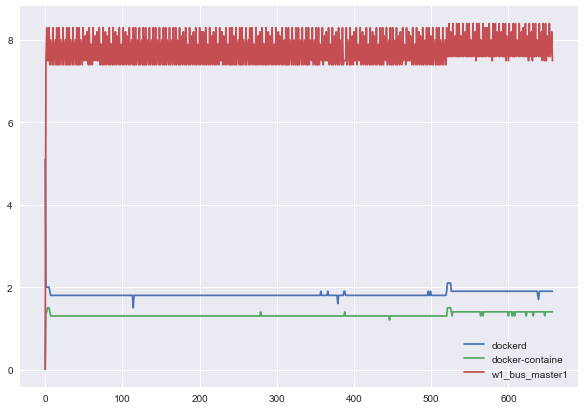

In [8]:
parseTop(PI, PIRESULT, avoid)
cpuPi, memPi = readFile(PIRESULT)

x = np.arange(0, len(cpuPi["455"]))

y1 = cpuPi["455"]
y2 = cpuPi["499"]
y3 = cpuPi["169"]

plt.figure(figsize=(10,7))
plt.plot(x, y1)
plt.plot(x, y2)
plt.plot(x, y3)

plt.legend(["dockerd", "docker-containe", "w1_bus_master1"], loc = "lower right")
plt.show()

For memory, the most consuming tasks are a little different. Docker consumes quite a bit of memory (PID = 455, 499) however the bus doesn't.

Through inspection, the sshd (PID = 448), bash (PID = 532), systemd (PID = 1), mtpd (PID = 475), vncserver (PID = 451) all consume >1% of %MEM.

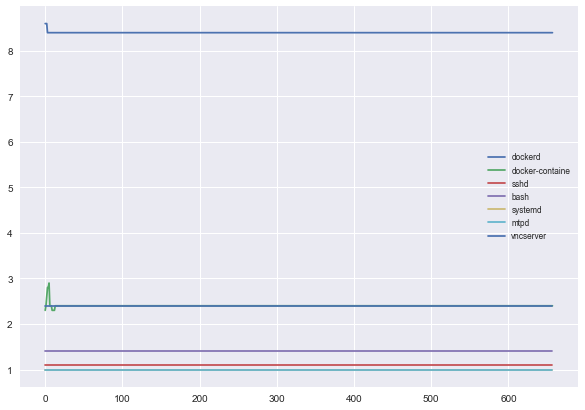

In [9]:
x = np.arange(0, len(memPi["455"]))

z1 = memPi["455"]
z2 = memPi["499"]
z3 = memPi["448"]
z4 = memPi["532"]
z5 = memPi["1"]
z6 = memPi["475"]
z7 = memPi["451"]

plt.figure(figsize=(10,7))
plt.plot(x, z1)
plt.plot(x, z2)
plt.plot(x, z3)
plt.plot(x, z4)
plt.plot(x, z5)
plt.plot(x, z6)
plt.plot(x, z7)

fontP = FontProperties()
fontP.set_size('small')

plt.legend(["dockerd", "docker-containe", "sshd", "bash", "systemd", "mtpd", "vncserver"],
          prop = fontP)
plt.show()

Now, it's time to see how much CPU/MEM the audio and fft take.

First, create the two dictionaries I will be graphing with

In [10]:
returnOne(PIPROGRAM, PIPROGRESULT, "main")
cpu, mem = readFile(PIPROGRESULT)

Then the creation of a simple line graph.

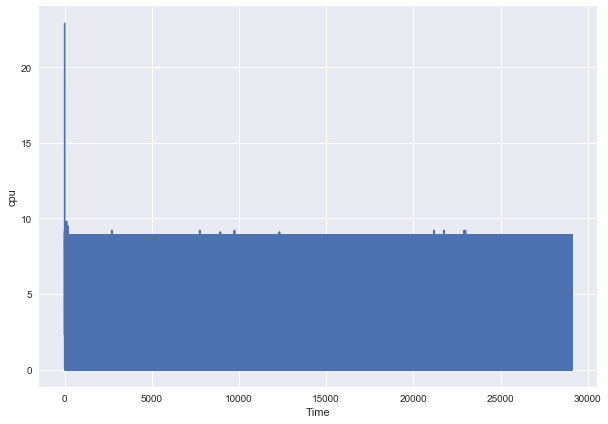

In [11]:
l = np.arange(0, len(cpu['21540']))
y = cpu['21540']

plt.figure(figsize=(10,7))
plt.plot(l, y)
plt.xlabel("Time")
plt.ylabel("cpu")
plt.show()

Unfortunately, when I was taking the results, I forgot to put in a reasonable delay. So, here I just graph only 100 results.

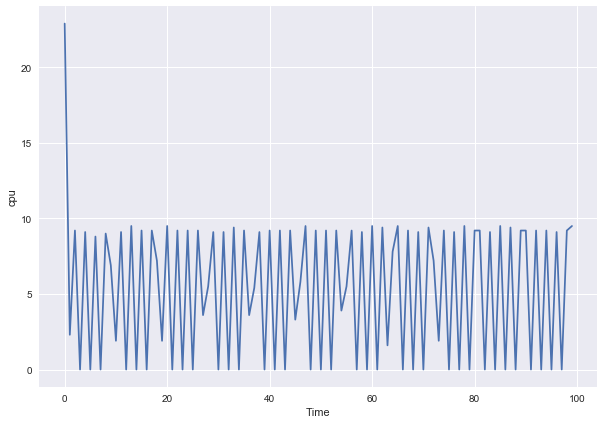

In [12]:
l1 = np.arange(0, len(cpu['21540'][0:100]))
f1 = cpu['21540'][0:100]

plt.figure(figsize=(10,7))
plt.plot(l1, f1)
plt.xlabel("Time")
plt.ylabel("cpu")
plt.show()

Now in terms of memory.

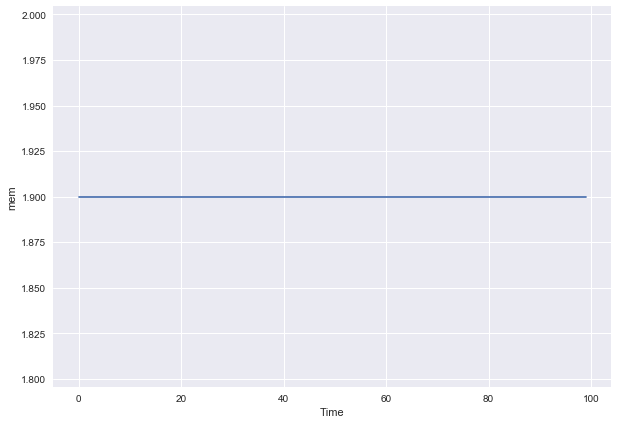

In [13]:
mx1 = np.arange(0, len(mem['21540'][0:100]))
my1 = mem['21540'][0:100]

plt.figure(figsize=(10,7))
plt.plot(mx1, my1)
plt.xlabel("Time")
plt.ylabel("mem")
plt.show()

## Deeper Look

### Raspberry Pi Idle Case

### CPU

From doing a more through inspection of the initial data, we can see that the there is something I missed initially.

Process 12328 consumes 11% of the cpu power on average. After that, only the 3 processes I mentioned consume any kind of real processor power. The rest is all sub 0.1% cpu. At a later stage, I will probably combine everyone of these cpu processes together.

Purely for finding some way of finding the CPU consumers, I decided to just rank them by average performance. Due to the nature of the data points, this isn't perfect as it is revealed that the highest average performer (PID = 12328) only ever has 2 values so it has a high performance of 11.25%. This means the choice of top 4 CPU hogs isn't perfect but it's somewhere to start.

In [14]:
def ave(d):
    '''
    This function takes in a dictionary {k : []}and returns an Ordered Dictionary
    The Ordered Dictionary has the same key as input dictionary
    Output is no longer a list but the mean of that list
    '''
    
    average = {}

    for k in d:
        mean = np.mean(d[k])
        average[k] = mean
        
    # Reverse has to be used here because the sorted function sorts from lowest to highest
    # Ultimately my use case doesn't care what order it is, but for printing it would be
    # nice to have highest to lowest
    return OrderedDict(sorted(average.items(), reverse = True, key = lambda t: t[1]))

sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 12328	Mean 11.25
Key: 169	Mean 7.76823708207
Key: 455	Mean 1.82887537994
Key: 499	Mean 1.31975683891
Key: 553	Mean 0.1
Key: 118	Mean 0.0998480243161
Key: 451	Mean 0.0998480243161
Key: 9259	Mean 0.090625
Key: 11974	Mean 0.0894736842105
Key: 10938	Mean 0.0888888888889


The following function deinition is simply a helper function to transform the dictionaries I created at the start into a much more useful to graph version. The original version was inconvenient to graph as it had to many key, value pairs. This function should reduce the key, value pairs to only certain keys that I care about. The rest of the key, value pairs are then combined together as just being a 'rest of them' key with a value being the direct addition of their lists.

In [15]:
keys = ['12328', '169', '455', '499']


def prep_for_graph(d, keys):
    '''
    d = Dictionary that will be reduced to be only the keys specified with the rest combined
    returns a reduced dictionary that only contains much less key, value pairs
    '''
    concise = {}
    t = []

    for k in d:
        if k in keys:
            concise[k] = d[k]
        else: # At this point, I want to add everything into an 'everything else' list
            t = [x + y for x, y in zip_longest(t, d[k], fillvalue = 0)]

    concise['all'] = t
    
    # Find what the largest list in the dictionary is
    largest = 0
    for k in concise:
        if len(concise[k]) > largest:
            largest = len(concise[k])
            
    for k in concise:
        if len(concise[k]) < largest:
            concise[k].extend([0] * (largest - len(concise[k])))
    
    return concise

concise = prep_for_graph(cpuPi, keys)

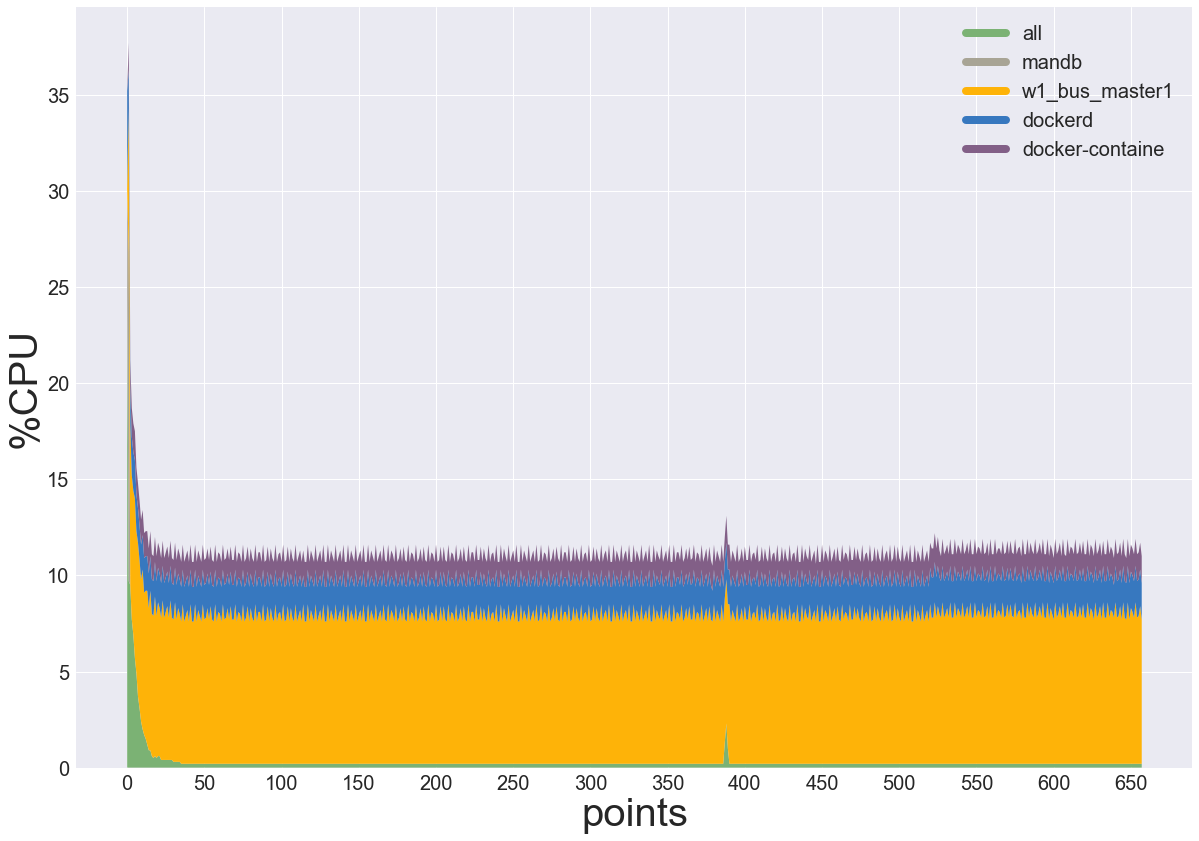

In [16]:
points = np.arange(0, len(concise['all']))
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87"]
fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'mandb',           linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_master1',  linewidth = 8)
ax.plot([], [], color = C[3], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker-containe', linewidth = 8)

ax.stackplot(points, concise['all'], concise['12328'], concise['169'],
             concise['455'], concise['499'], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_xticks(np.arange(0, 700, 50))
ax.set_yticks(np.arange(0, 40, 5))
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

### MEM

At this point, Iḿ just reusing the same functions that I did for the CPU portion. If you have read the CPU section, there is pretty much no need for further explanation.

The only key difference is that I kept the names of more values. As can be seen in the output of the cell right below, a lot of processes are using a little bit of memory. Docker is the most memory intensive application by far however quite a few processes hover at 1% average memory usage.

In [17]:
sortedMEM = ave(memPi)

i = 0
for k in sortedMEM:
    if i == 10:
        break
        
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedMEM[k]))
    

Key: 455	Mean 8.4009118541
Key: 499	Mean 2.40151975684
Key: 451	Mean 2.4
Key: 532	Mean 1.4
Key: 448	Mean 1.1
Key: 1	Mean 1.0
Key: 475	Mean 1.0
Key: 118	Mean 0.996048632219
Key: 12328	Mean 0.95
Key: 515	Mean 0.9


All of the names of each PID are found in the results txt file.

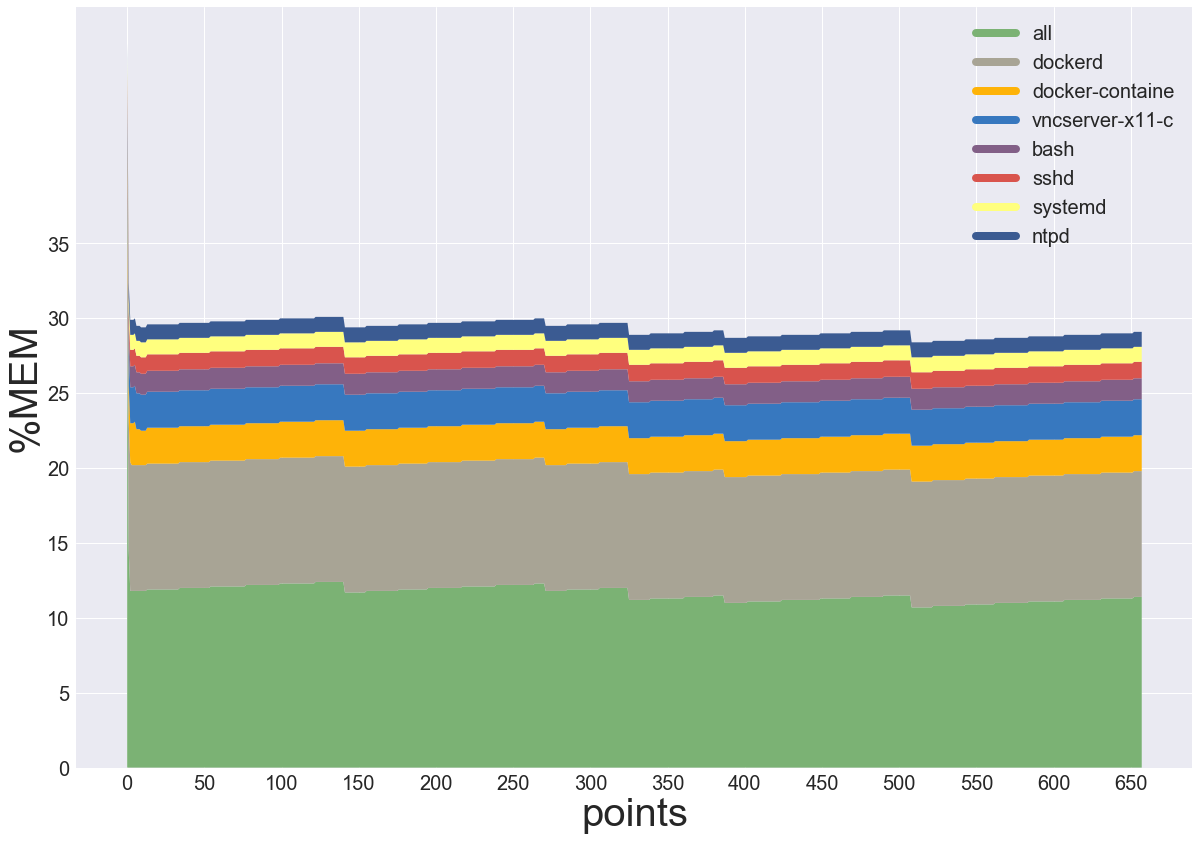

In [18]:
keys = ['455', '499', '451', '532', '448', '1', '475']
conMem = prep_for_graph(memPi, keys)

points = np.arange(0, len(conMem['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',              linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',          linewidth = 8)
ax.plot([], [], color = C[2], label = 'docker-containe',  linewidth = 8)
ax.plot([], [], color = C[3], label = 'vncserver-x11-c',  linewidth = 8)
ax.plot([], [], color = C[4], label = 'bash',             linewidth = 8)
ax.plot([], [], color = C[5], label = 'sshd',             linewidth = 8)
ax.plot([], [], color = C[6], label = 'systemd',          linewidth = 8)
ax.plot([], [], color = C[7], label = 'ntpd',             linewidth = 8)

ax.stackplot(points, conMem['all'], conMem['455'], conMem['499'],
             conMem['451'], conMem['532'], conMem['448'], conMem['1'], conMem['475'], colors = C)

ax.set_ylabel('%MEM', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_xticks(np.arange(0, 700, 50))
ax.set_yticks(np.arange(0, 40, 5))
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

# More Testing (Improved Graphs)

I reran every single test to just confirm the performance characteristics first found.

I also wanted to improve the graphing significantly.

Should be noted that for every single test except for the very first 1, the sample interval is 0.5 s and the first graph has a sample interval of 0.1 s. This means that 100 data points should equal to 50 seconds.

Key: 707	Mean 8.3462566514
Key: 170	Mean 7.60469001361
Key: 860	Mean 5.5
Key: 911	Mean 5.5
Key: 1051	Mean 5.5
Key: 1316	Mean 5.5
Key: 1355	Mean 5.5
Key: 1492	Mean 5.5
Key: 1494	Mean 5.5
Key: 1551	Mean 5.5


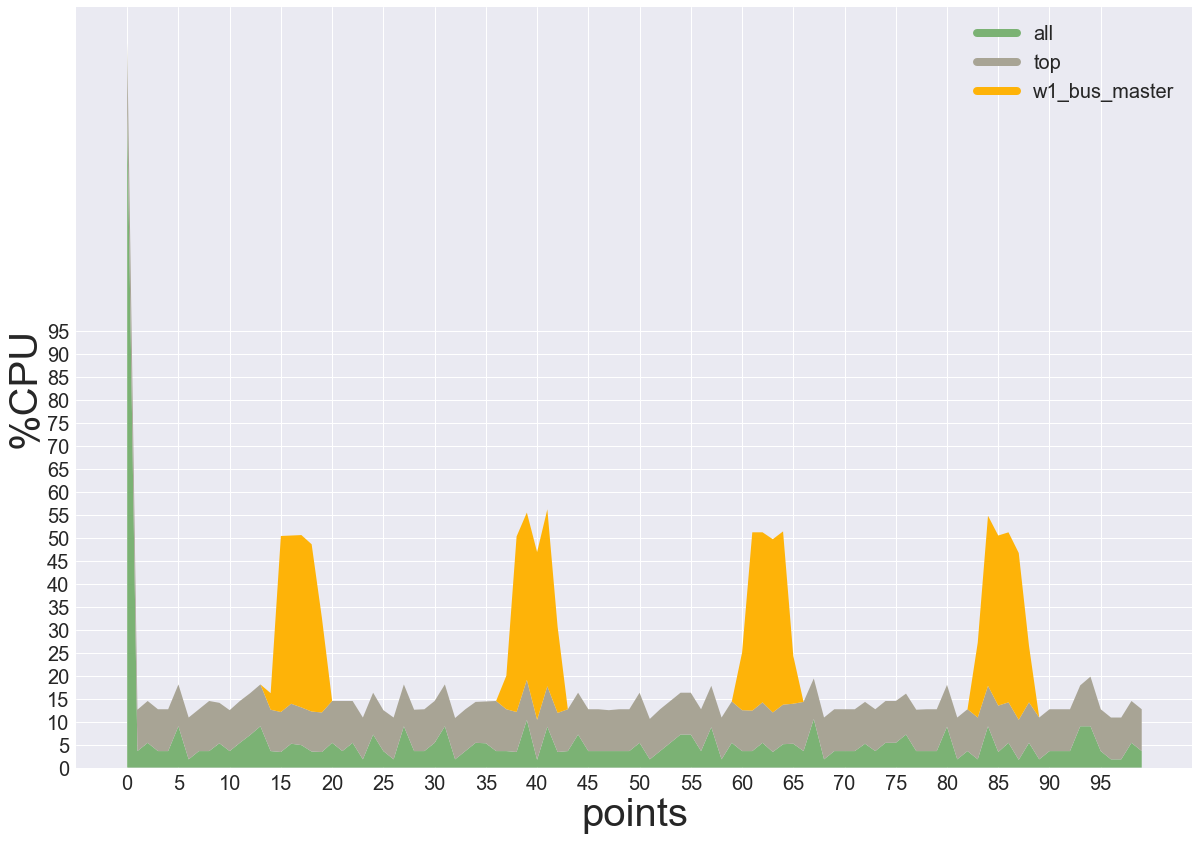

Key: 1802	Mean 8.27444046553
Key: 170	Mean 7.6245747538
Key: 1814	Mean 5.5
Key: 1899	Mean 5.5
Key: 2138	Mean 5.5
Key: 2272	Mean 5.5
Key: 2288	Mean 5.5
Key: 2334	Mean 5.5
Key: 2354	Mean 5.5
Key: 2437	Mean 5.5


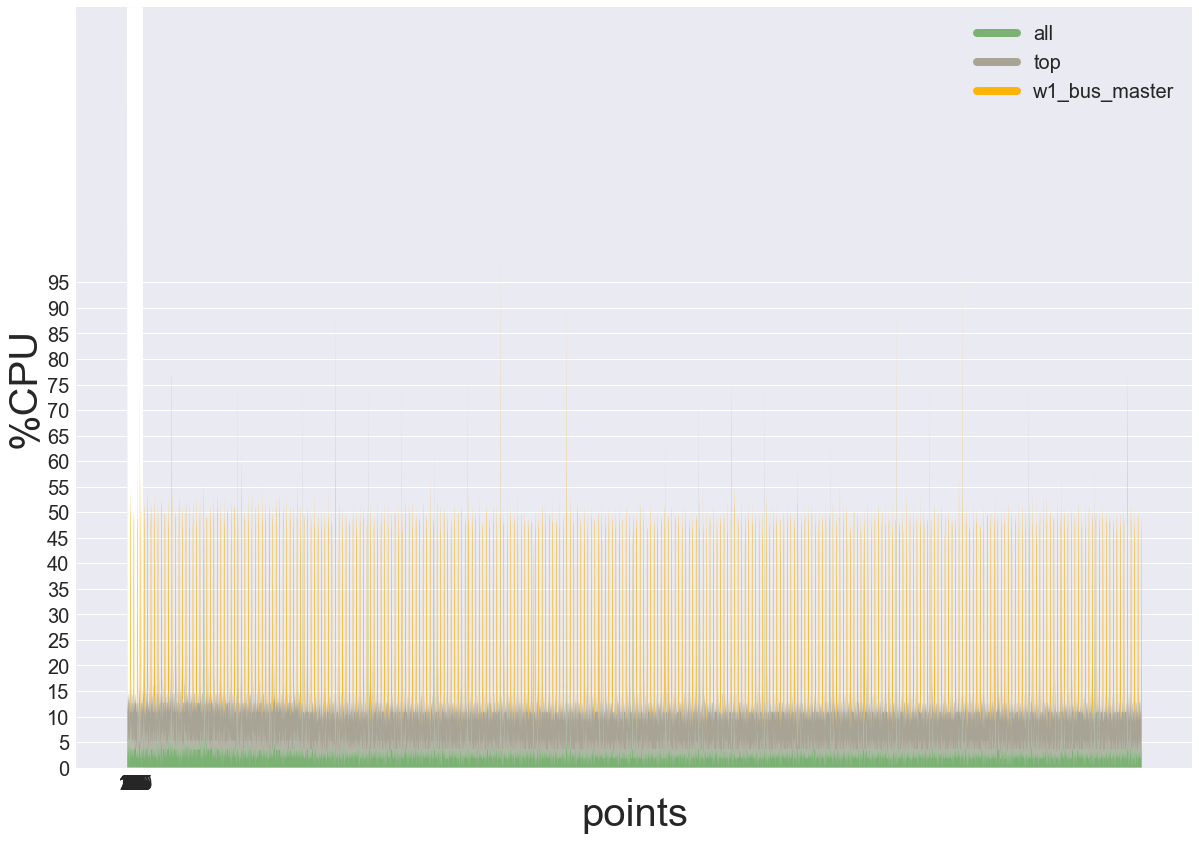

Key: 7058	Mean 8.07601481075
Key: 170	Mean 7.64245748766
Key: 7062	Mean 5.5
Key: 7066	Mean 5.5
Key: 7115	Mean 5.5
Key: 7137	Mean 5.5
Key: 7165	Mean 5.5
Key: 7186	Mean 5.5
Key: 7748	Mean 5.5
Key: 7822	Mean 5.5


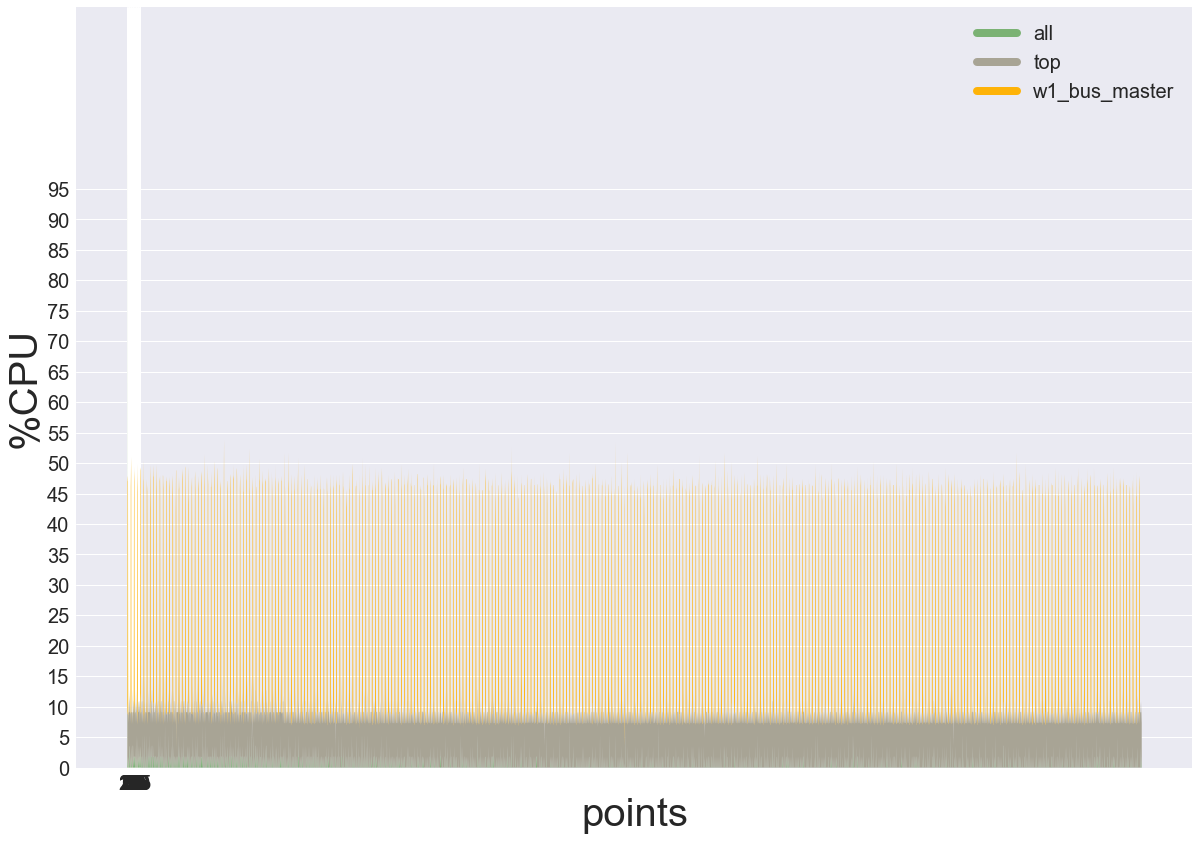

In [19]:
parseTop(tn1, tn1result, avoid)
cpuPi, memPi = readFile(tn1result)
sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['707', '170'] # 707 = top, 170 = w1 bus master
concise = prep_for_graph(cpuPi, keys)

#### Graphing
points = np.arange(0, 100)

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',              linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',              linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_master',    linewidth = 8)

ax.stackplot(points, concise['all'][:100], concise['707'][:100], concise['170'][:100], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.set_xticks(np.arange(0, 100, 5))
ax.set_yticks(np.arange(0, 100, 5))
ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()

####
# Second Graph
###

parseTop(tn2, tn2result, avoid)
cpuPi, memPi2 = readFile(tn2result)
sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['1802', '170'] # 1802 = top, 170 = w1 bus master, everything using 5.5% is vncagent

concise = prep_for_graph(cpuPi, keys)

#### Graphing
points = np.arange(0, len(concise['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',              linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',              linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_master',    linewidth = 8)

ax.stackplot(points, concise['all'], concise['1802'], concise['170'], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.set_xticks(np.arange(0, 100, 5))
ax.set_yticks(np.arange(0, 100, 5))
ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()


###
# Third Graph
###

parseTop(tn7, tn7result, avoid)
cpuPi, memPi3 = readFile(tn7result)
sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['7058', '170'] # 7058 = top, 170 = w1 bus master
concise = prep_for_graph(cpuPi, keys)

# Graphing
points = np.arange(0, len(concise['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',              linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',              linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_master',    linewidth = 8)

ax.stackplot(points, concise['all'], concise['7058'], concise['170'], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.set_xticks(np.arange(0, 100, 5))
ax.set_yticks(np.arange(0, 100, 5))
ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()

Key: 462	Mean 8.40503650538
Key: 460	Mean 2.4
Key: 506	Mean 2.35952233634
Key: 544	Mean 1.4
Key: 455	Mean 1.2
Key: 1	Mean 1.0
Key: 481	Mean 1.0
Key: 525	Mean 0.9
Key: 921	Mean 0.9
Key: 120	Mean 0.8


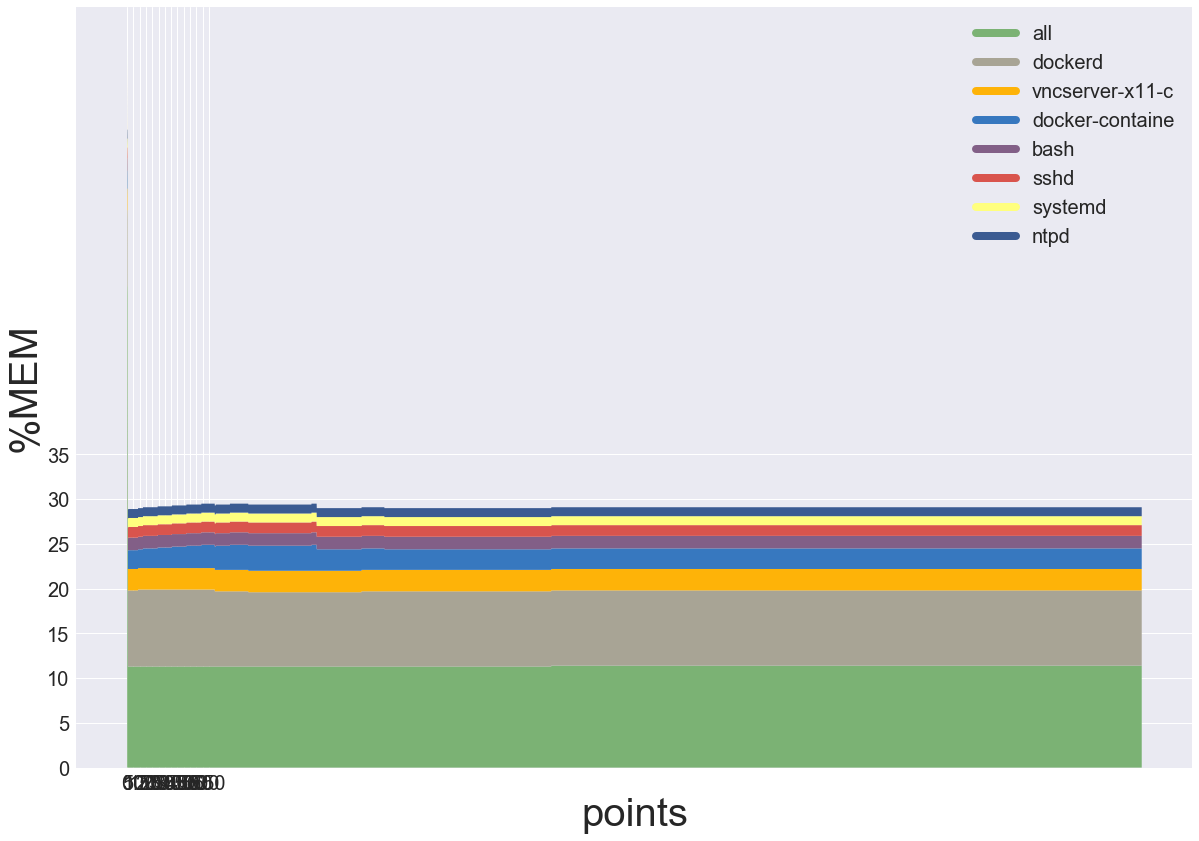

Key: 460	Mean 2.4
Key: 544	Mean 1.4
Key: 455	Mean 1.2
Key: 1	Mean 1.0
Key: 481	Mean 1.0
Key: 118	Mean 0.994925946242
Key: 525	Mean 0.9
Key: 120	Mean 0.8
Key: 377	Mean 0.8
Key: 416	Mean 0.8


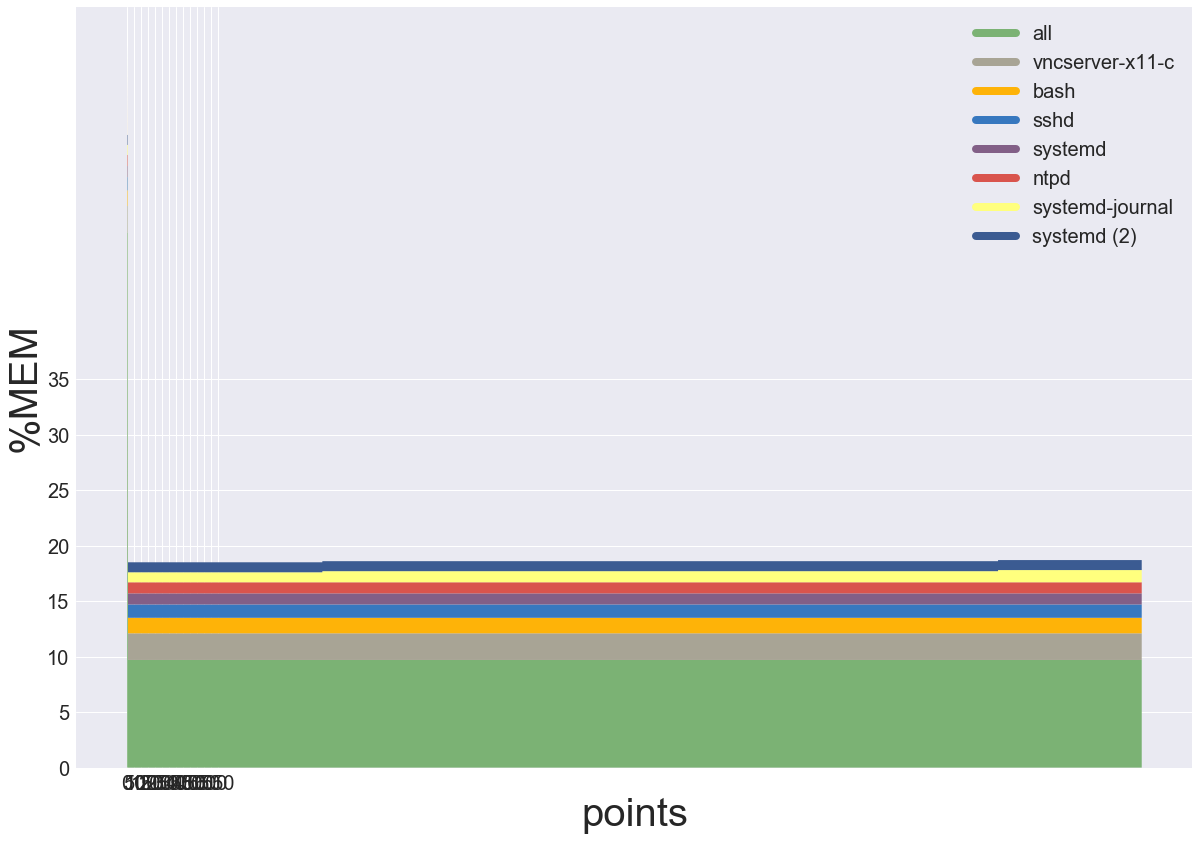

In [20]:
sortedMEM = ave(memPi)

i = 0
for k in sortedMEM:
    if i == 10:
        break
        
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedMEM[k]))
    
# 462 = Dockerd, 460 = vncserver-x11-c, 506 = docker-containe, 544 = bash
# 455 = sshd, 1 = systemd, 481 =ntpd
keys = ['462', '460', '506', '544', '455', '1', '481']
conMem = prep_for_graph(memPi, keys)

# Graphing
points = np.arange(0, len(conMem['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',              linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',          linewidth = 8)
ax.plot([], [], color = C[2], label = 'vncserver-x11-c',  linewidth = 8)
ax.plot([], [], color = C[3], label = 'docker-containe',  linewidth = 8)
ax.plot([], [], color = C[4], label = 'bash',             linewidth = 8)
ax.plot([], [], color = C[5], label = 'sshd',             linewidth = 8)
ax.plot([], [], color = C[6], label = 'systemd',          linewidth = 8)
ax.plot([], [], color = C[7], label = 'ntpd',             linewidth = 8)

ax.stackplot(points, conMem['all'], conMem['462'], conMem['460'],
             conMem['506'], conMem['544'], conMem['455'], conMem['1'], conMem['481'], colors = C)

ax.set_ylabel('%MEM', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_xticks(np.arange(0, 700, 50))
ax.set_yticks(np.arange(0, 40, 5))
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

#####
# Graph 2
#####

sortedMEM = ave(memPi3)

i = 0
for k in sortedMEM:
    if i == 10:
        break
        
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedMEM[k]))
    
# 460 = vncserver-x11-c, 544 = bash, 455 = sshd, 1 = systemd
# 481 = ntpd, 118 = systemd-journal, 525 = systemd

keys = ['460', '544', '455', '1', '481', '118', '525']
conMem = prep_for_graph(memPi3, keys)

# Graphing
points = np.arange(0, len(conMem['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',              linewidth = 8)
ax.plot([], [], color = C[1], label = 'vncserver-x11-c',  linewidth = 8)
ax.plot([], [], color = C[2], label = 'bash',             linewidth = 8)
ax.plot([], [], color = C[3], label = 'sshd',             linewidth = 8)
ax.plot([], [], color = C[4], label = 'systemd',          linewidth = 8)
ax.plot([], [], color = C[5], label = 'ntpd',             linewidth = 8)
ax.plot([], [], color = C[6], label = 'systemd-journal',  linewidth = 8)
ax.plot([], [], color = C[7], label = 'systemd (2)',      linewidth = 8)

ax.stackplot(points, conMem['all'], conMem['460'], conMem['544'],
             conMem['455'], conMem['1'], conMem['481'], conMem['118'], conMem['525'], colors = C)

ax.set_ylabel('%MEM', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_xticks(np.arange(0, 700, 50))
ax.set_yticks(np.arange(0, 40, 5))
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

### Raspberry Pi Running Program

### CPU

Now with the program running

Key: 1088	Mean 72.3
Key: 1021	Mean 64.7666666667
Key: 972	Mean 55.7727272727
Key: 1059	Mean 26.7
Key: 980	Mean 16.2
Key: 994	Mean 15.3
Key: 1000	Mean 12.6
Key: 990	Mean 11.2
Key: 1004	Mean 11.0
Key: 966	Mean 10.2


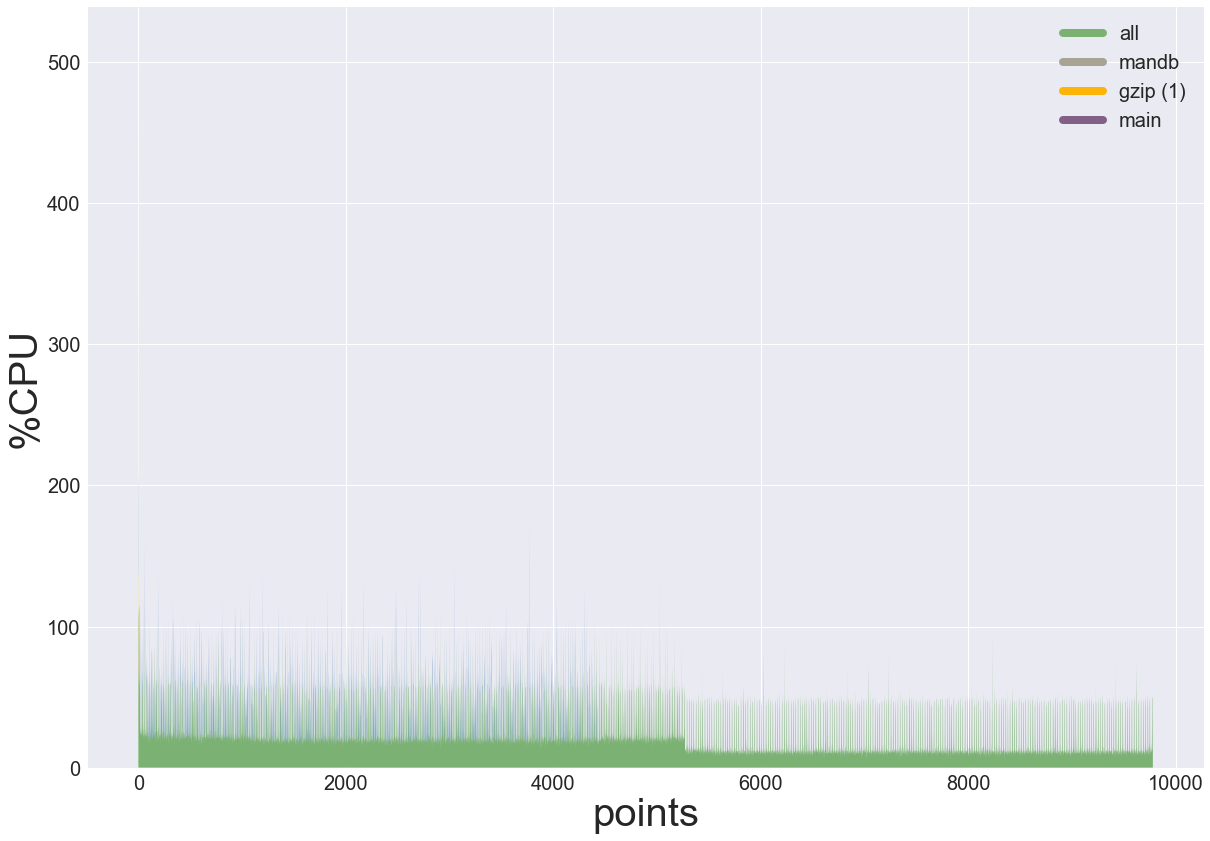

Key: 3204	Mean 12.35
Key: 3201	Mean 8.91935483871
Key: 3214	Mean 8.33686189443
Key: 169	Mean 7.60170560413
Key: 3207	Mean 7.1
Key: 3397	Mean 5.5
Key: 3422	Mean 5.5
Key: 3633	Mean 5.5
Key: 3870	Mean 5.5
Key: 4054	Mean 5.5


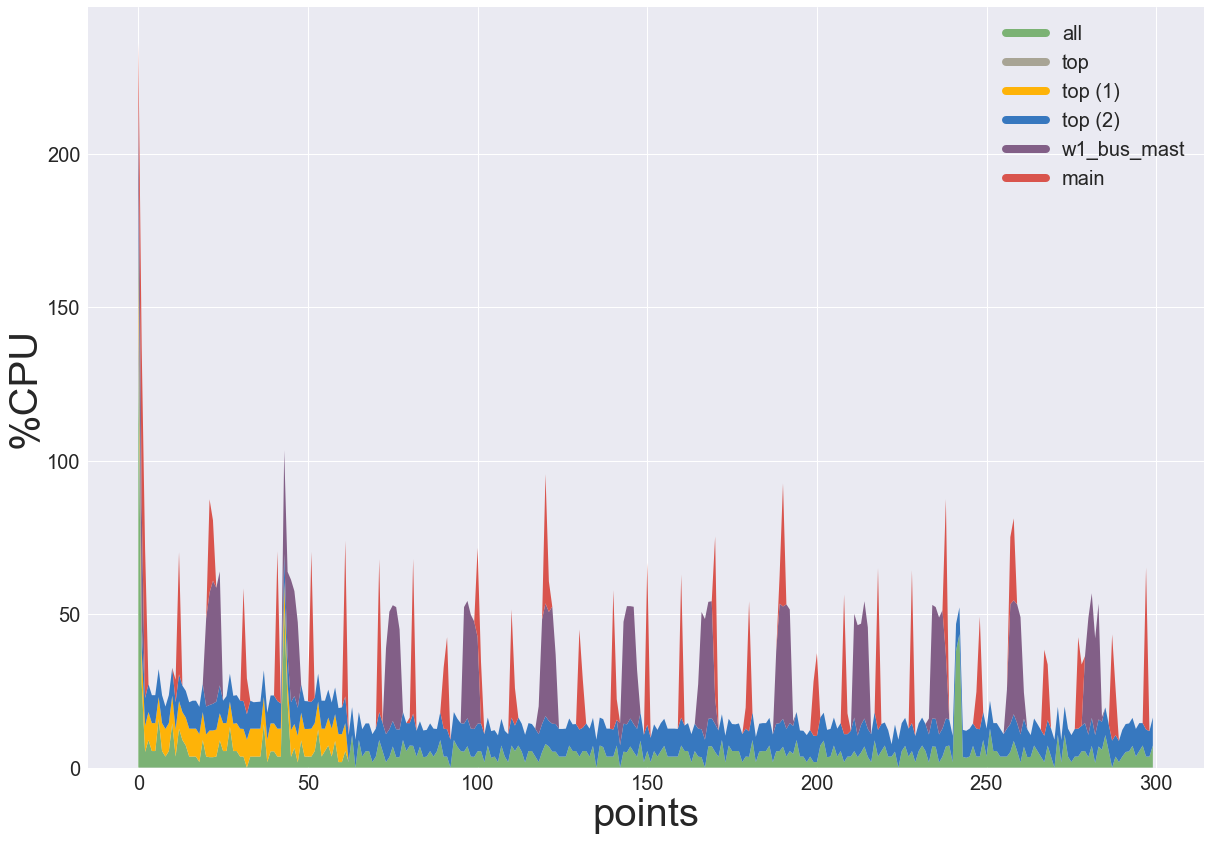

Key: 6614	Mean 8.63274798291
Key: 169	Mean 7.59258028793
Key: 7042	Mean 5.5
Key: 7064	Mean 5.5
Key: 6721	Mean 5.4
Key: 6740	Mean 5.4
Key: 7386	Mean 5.4
Key: 6616	Mean 5.2
Key: 6617	Mean 4.91972301815
Key: 7224	Mean 3.7


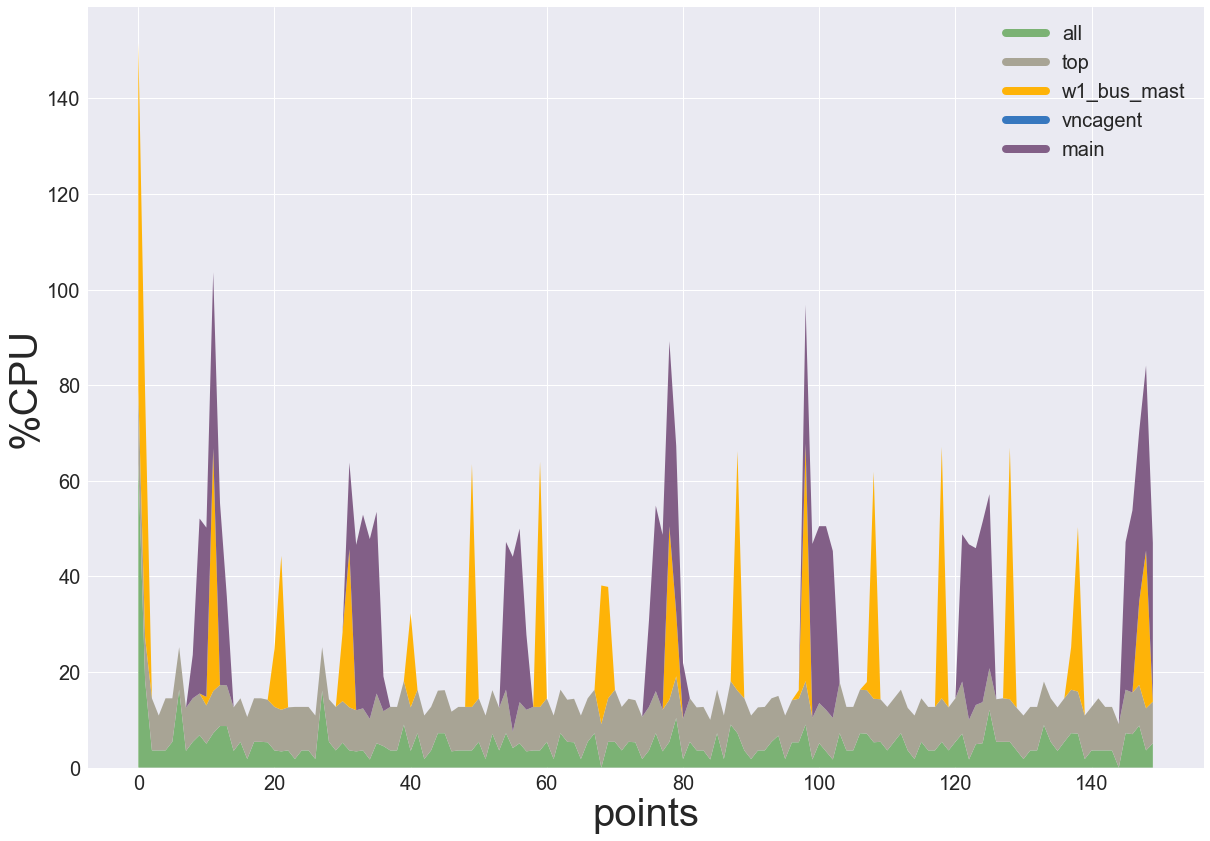

In [21]:
parseTop(tp1, tp1result, avoid)
cpuPi, memPi = readFile(tp1result)
sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['1088', '1021', '719'] # 1059, 2021 = gzip, 1088 = mandb, 719 = main, 972 = apt-get, 
concise = prep_for_graph(cpuPi, keys)

###
# Graph
###
points = np.arange(0, len(concise['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',         linewidth = 8)
ax.plot([], [], color = C[1], label = 'mandb',       linewidth = 8)
ax.plot([], [], color = C[2], label = 'gzip (1)',    linewidth = 8)
ax.plot([], [], color = C[4], label = 'main',        linewidth = 8)

ax.stackplot(points, concise['all'], concise['1088'],
             concise['1021'], concise['719'], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()

###
# Graph 2
###

parseTop(tp3, tp3result, avoid)
cpuPi, memPi2 = readFile(tp3result)
sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['3204', '3201', '3214', '169', '3217'] # 3204, 3201, 3214 = top, 169 = w1_bus_mast, 3217 = main 
concise = prep_for_graph(cpuPi, keys)

###
# Graph
###
points = np.arange(0, 300)

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',         linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',         linewidth = 8)
ax.plot([], [], color = C[2], label = 'top (1)',     linewidth = 8)
ax.plot([], [], color = C[3], label = 'top (2)',     linewidth = 8)
ax.plot([], [], color = C[4], label = 'w1_bus_mast', linewidth = 8)
ax.plot([], [], color = C[5], label = 'main',        linewidth = 8)


ax.stackplot(points, concise['all'][:300], concise['3204'][:300], concise['3201'][:300], concise['3214'][:300],
             concise['169'][:300], concise['3217'][:300], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()

###
# Graph 3
###

parseTop(tp7, tp7result, avoid)
cpuPi, memPi3 = readFile(tp7result)
sortedCPU = ave(cpuPi)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['6614', '6617', '7402', '169'] # 6614 = top, 169 = w1_bus_mast, 7402 = vncagent, 6617 = main 
concise = prep_for_graph(cpuPi, keys)

###
# Graph
###
points = np.arange(0, 150)

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',         linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',         linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_mast', linewidth = 8)
ax.plot([], [], color = C[3], label = 'vncagent',    linewidth = 8)
ax.plot([], [], color = C[4], label = 'main',        linewidth = 8)


ax.stackplot(points, concise['all'][:150], concise['6614'][:150], concise['6617'][:150],
             concise['7402'][:150], concise['169'][:150], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()

### Memory

Key: 467	Mean 8.4
Key: 464	Mean 2.4
Key: 511	Mean 2.3
Key: 6617	Mean 1.98457497612
Key: 564	Mean 1.4
Key: 460	Mean 1.2
Key: 1	Mean 1.0
Key: 485	Mean 1.0
Key: 118	Mean 0.915472235406
Key: 542	Mean 0.9


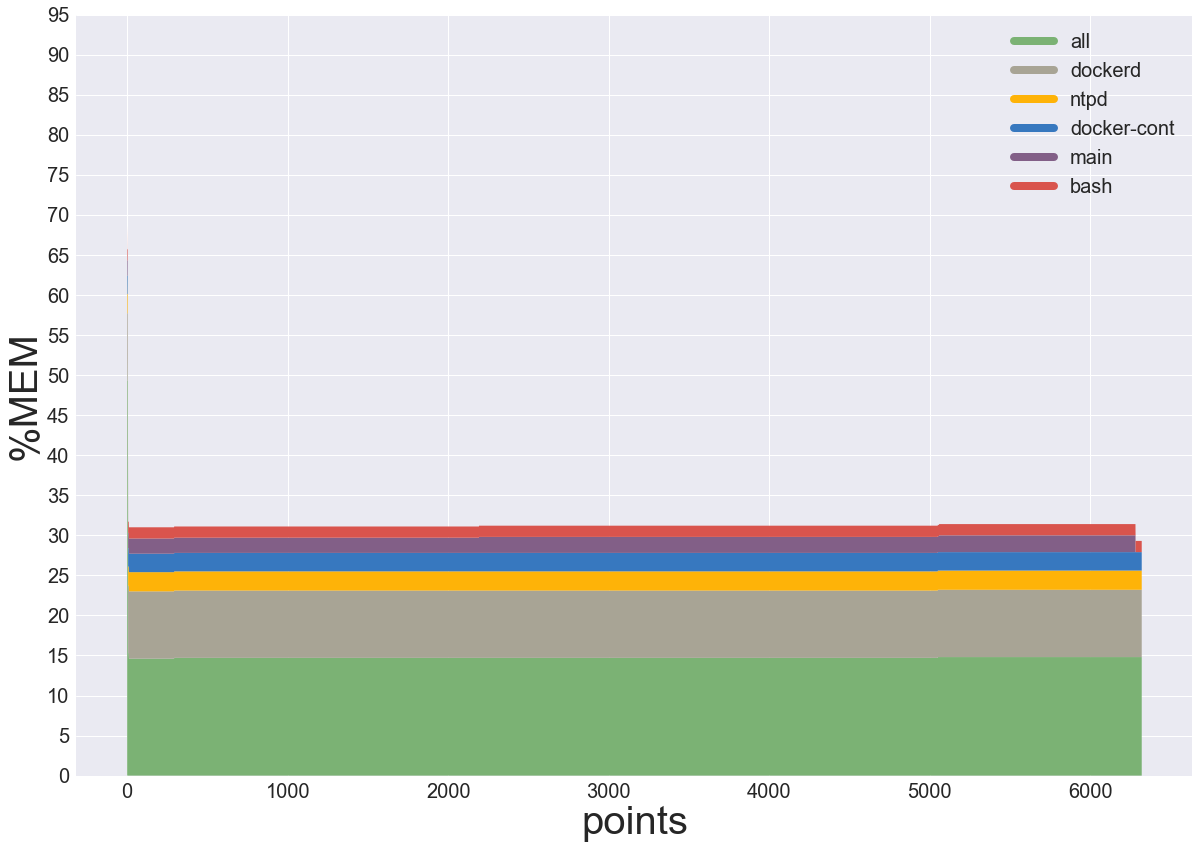

In [22]:
sortedMEM = ave(memPi3)

i = 0
for k in sortedMEM:
    if i == 10:
        break
        
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedMEM[k]))
    
# 460 = vncserver-x11-c, 544 = bash, 455 = sshd, 1 = systemd
# 481 = ntpd, 118 = systemd-journal, 525 = systemd

# 467 = dockerd, 464 = ntpd, 511 = docker-cont, 6617 = main, 564 = bash
keys = ['467', '464', '511', '6617', '564']
conMem = prep_for_graph(memPi3, keys)

# Graphing
points = np.arange(0, len(conMem['all']))

C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',          linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',      linewidth = 8)
ax.plot([], [], color = C[2], label = 'ntpd',         linewidth = 8)
ax.plot([], [], color = C[3], label = 'docker-cont',  linewidth = 8)
ax.plot([], [], color = C[4], label = 'main',         linewidth = 8)
ax.plot([], [], color = C[5], label = 'bash',         linewidth = 8)

ax.stackplot(points, conMem['all'], conMem['467'], conMem['464'],
             conMem['511'], conMem['6617'], conMem['564'], colors = C)

ax.set_ylabel('%MEM', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_yticks(np.arange(0, 100, 5))
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

# Docker

### CPU

Now, I will start doing some performance analysis on the running the program inside a docker container. To begin with, I will start by listing all of the Docker text file locations.

In [23]:
docker1 = "../Input/Docker/docker.txt"
docker2 = "../Input/Docker/docker2.txt"
docker3 = "../Input/Docker/docker3.txt" 
docker4 = "../Input/Docker/docker4.txt"
docker5 = "../Input/Docker/docker5.txt" 
docker6 = "../Input/Docker/docker6.txt"

# Results locations
result1 = "../Results/Docker/result1.txt"
result2 = "../Results/Docker/result2.txt"
result3 = "../Results/Docker/result3.txt"
result4 = "../Results/Docker/result4.txt"
result5 = "../Results/Docker/result5.txt"
result6 = "../Results/Docker/result6.txt"

Now, I will perform the processing of the text files to obtain the data stream.

In [24]:
parseTop(docker1, result1, avoid)
cpu, mem = readFile(result1)

parseTop(docker2, result2, avoid)
cpu2, mem2 = readFile(result2)

parseTop(docker3, result3, avoid)
cpu3, mem3 = readFile(result3)

parseTop(docker4, result4, avoid)
cpu4, mem4 = readFile(result4)

parseTop(docker5, result5, avoid)
cpu5, mem5 = readFile(result5)

sortedCPU = ave(cpu)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 12980	Mean 30.6
Key: 12975	Mean 21.0
Key: 12850	Mean 9.79629674161
Key: 12919	Mean 9.2
Key: 168	Mean 7.44917638572
Key: 13058	Mean 4.77766214908
Key: 13227	Mean 3.4
Key: 12877	Mean 2.9
Key: 12878	Mean 2.9
Key: 12924	Mean 2.9


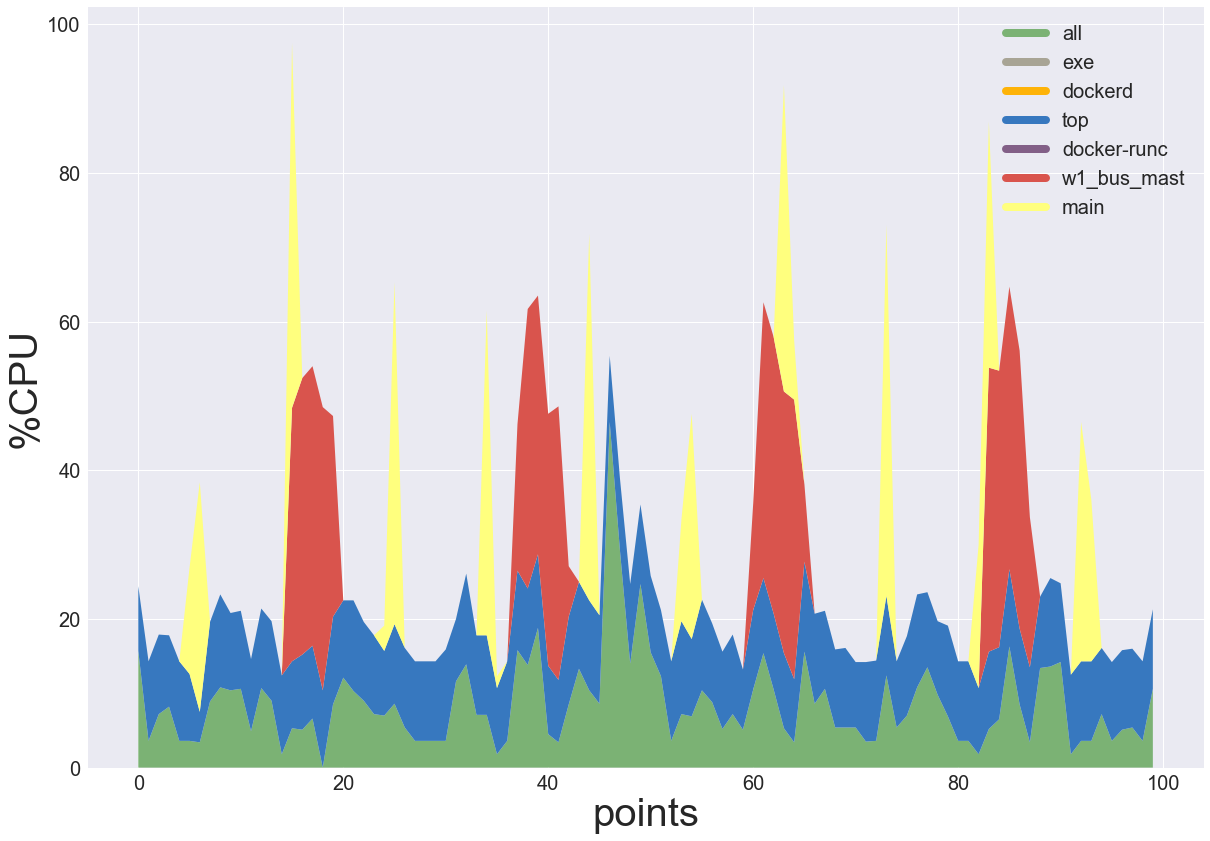

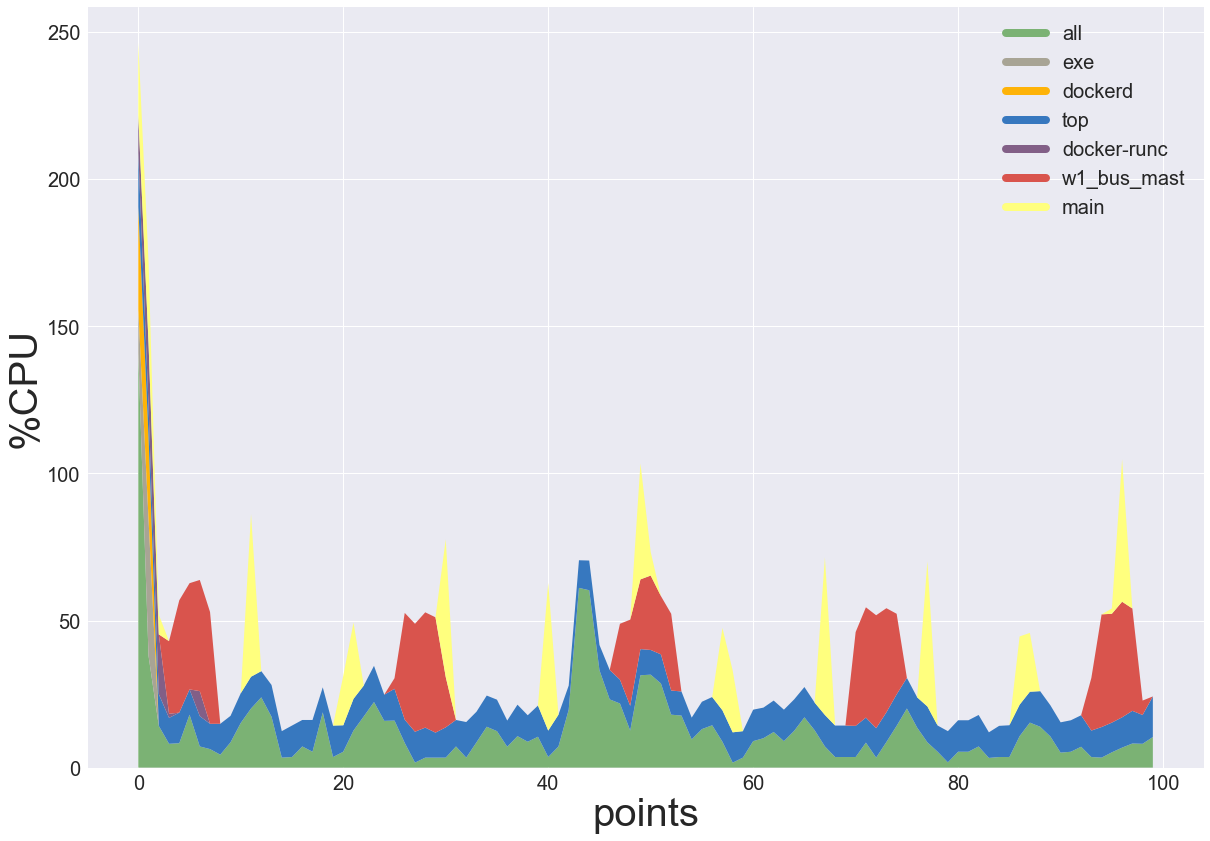

In [25]:
keys = ['12980', '12975', '12850', '12919', '168', '13058']
concise = prep_for_graph(cpu, keys)

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'exe',             linewidth = 8)
ax.plot([], [], color = C[2], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[3], label = 'top',             linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker-runc',     linewidth = 8)
ax.plot([], [], color = C[5], label = 'w1_bus_mast',     linewidth = 8)
ax.plot([], [], color = C[6], label = 'main',            linewidth = 8)

# saving the main data
main1 = concise['13058']

ax.stackplot(points, concise['all'][100:200], concise['12980'][100:200], concise['12975'][100:200],
             concise['12850'][100:200], concise['12919'][100:200], concise['168'][100:200], concise['13058'][100:200], 
             colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'exe',             linewidth = 8)
ax.plot([], [], color = C[2], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[3], label = 'top',             linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker-runc',     linewidth = 8)
ax.plot([], [], color = C[5], label = 'w1_bus_mast',     linewidth = 8)
ax.plot([], [], color = C[6], label = 'main',            linewidth = 8)

ax.stackplot(points, concise['all'][0:100], concise['12980'][0:100], concise['12975'][0:100],
             concise['12850'][0:100], concise['12919'][0:100], concise['168'][0:100], concise['13058'][0:100], 
             colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

In [26]:
sortedCPU = ave(cpu2)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 838	Mean 33.5
Key: 844	Mean 25.2
Key: 878	Mean 21.3
Key: 823	Mean 12.56
Key: 1340	Mean 10.6
Key: 729	Mean 9.56666666667
Key: 714	Mean 9.41
Key: 749	Mean 8.83798143393
Key: 168	Mean 7.55795343377
Key: 1329	Mean 5.5


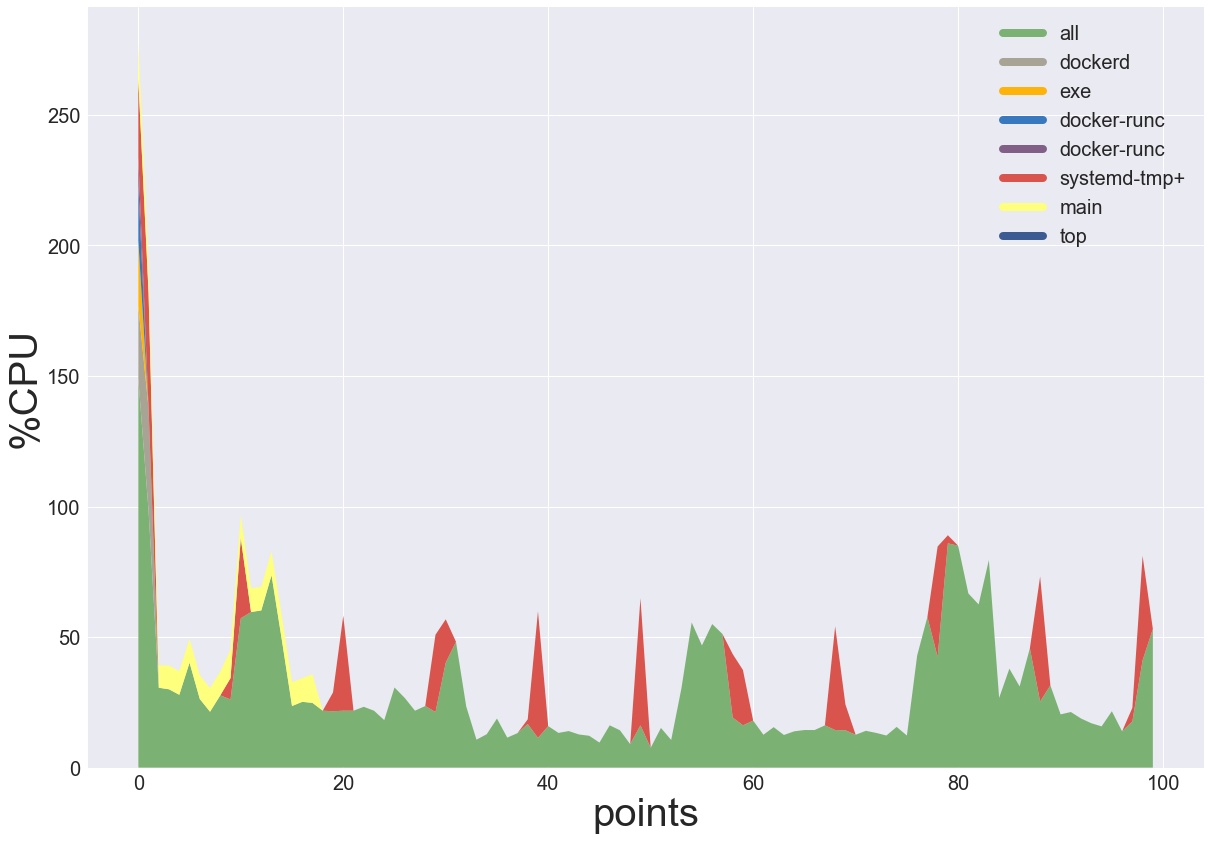

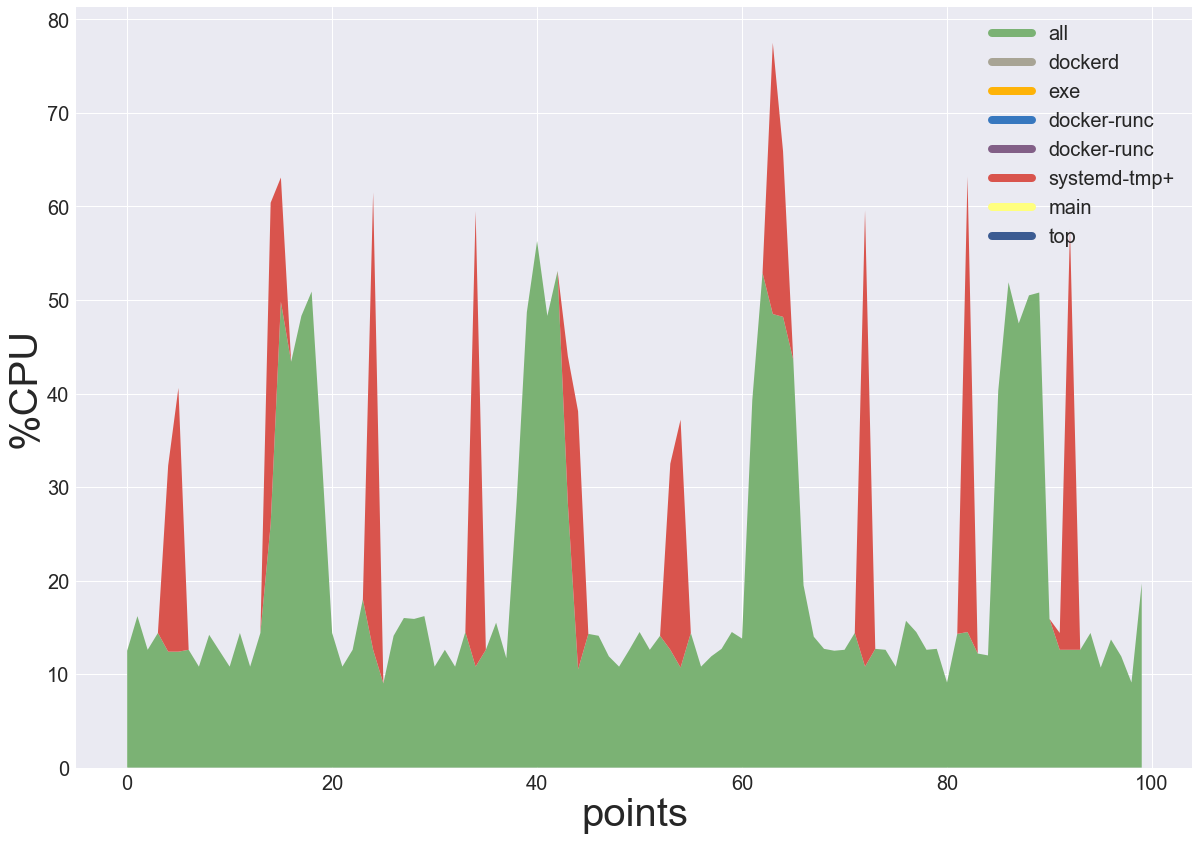

In [27]:
keys = ['838', '844', '878', '823', '1340', '942', '729']

concise = prep_for_graph(cpu2, keys)

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[2], label = 'exe',             linewidth = 8)
ax.plot([], [], color = C[3], label = 'docker-runc',     linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker-runc',     linewidth = 8)
ax.plot([], [], color = C[5], label = 'systemd-tmp+',    linewidth = 8)
ax.plot([], [], color = C[6], label = 'main',            linewidth = 8)
ax.plot([], [], color = C[7], label = 'top',             linewidth = 8)

main2 = concise['942']

ax.stackplot(points, concise['all'][0:100], concise['838'][0:100], concise['844'][0:100],
             concise['878'][0:100], concise['1340'][0:100], concise['942'][0:100], concise['729'][0:100], 
             colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',             linewidth = 8)
ax.plot([], [], color = C[2], label = 'exe',         linewidth = 8)
ax.plot([], [], color = C[3], label = 'docker-runc',             linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker-runc',     linewidth = 8)
ax.plot([], [], color = C[5], label = 'systemd-tmp+',     linewidth = 8)
ax.plot([], [], color = C[6], label = 'main',            linewidth = 8)
ax.plot([], [], color = C[7], label = 'top',            linewidth = 8)

ax.stackplot(points, concise['all'][1000:1100], concise['838'][1000:1100], concise['844'][1000:1100],
             concise['878'][1000:1100], concise['1340'][1000:1100], concise['942'][1000:1100], concise['729'][1000:1100], 
             colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

In [28]:
sortedCPU = ave(cpu3)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 845	Mean 33.45
Key: 819	Mean 13.775
Key: 883	Mean 11.7
Key: 717	Mean 9.95
Key: 720	Mean 9.00155656109
Key: 169	Mean 7.5556097561
Key: 851	Mean 6.4
Key: 1687	Mean 5.5
Key: 1198	Mean 5.4
Key: 1751	Mean 5.4


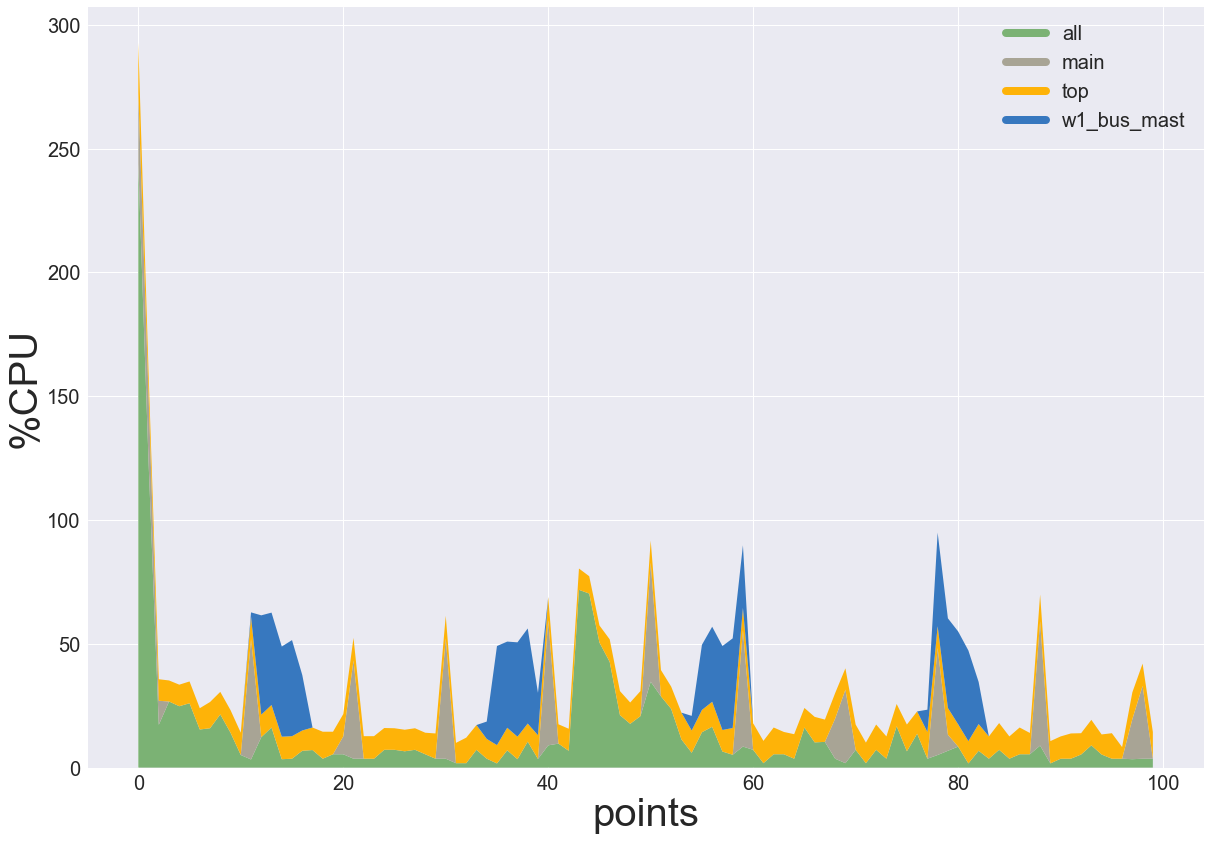

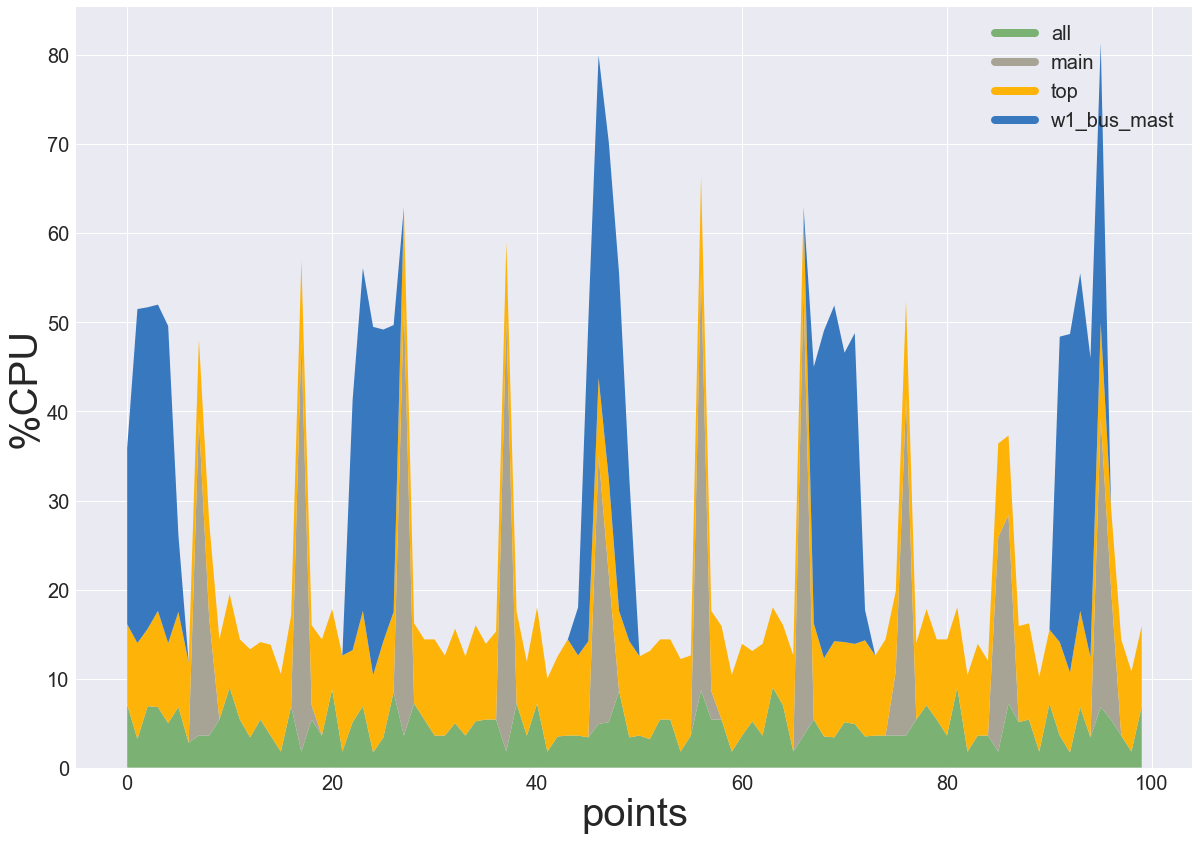

In [29]:
keys = ['947', '720', '169']

concise = prep_for_graph(cpu3,keys)

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'main',            linewidth = 8)
ax.plot([], [], color = C[2], label = 'top',             linewidth = 8)
ax.plot([], [], color = C[3], label = 'w1_bus_mast',     linewidth = 8)

main3 = concise['947']

ax.stackplot(points, concise['all'][0:100], concise['947'][0:100],
             concise['720'][0:100], concise['169'][0:100], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'main',            linewidth = 8)
ax.plot([], [], color = C[2], label = 'top',             linewidth = 8)
ax.plot([], [], color = C[3], label = 'w1_bus_mast',     linewidth = 8)

ax.stackplot(points, concise['all'][100:200], concise['947'][100:200],
             concise['720'][100:200], concise['169'][100:200], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

In [30]:
sortedCPU = ave(cpu4)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

Key: 846	Mean 34.8
Key: 886	Mean 21.7
Key: 852	Mean 20.9
Key: 827	Mean 12.4
Key: 719	Mean 10.075
Key: 722	Mean 8.94877978339
Key: 165	Mean 7.59727233367
Key: 1254	Mean 5.4
Key: 1262	Mean 5.4
Key: 1278	Mean 5.4


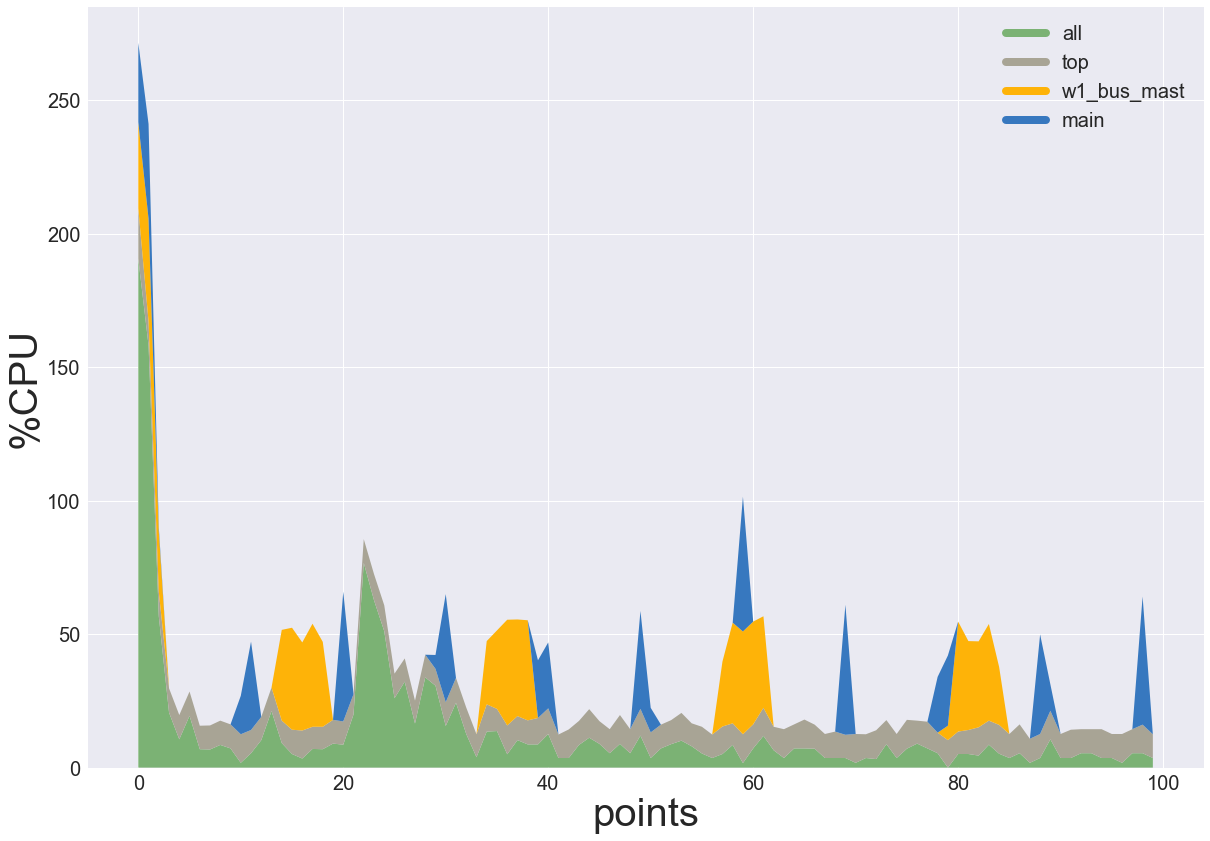

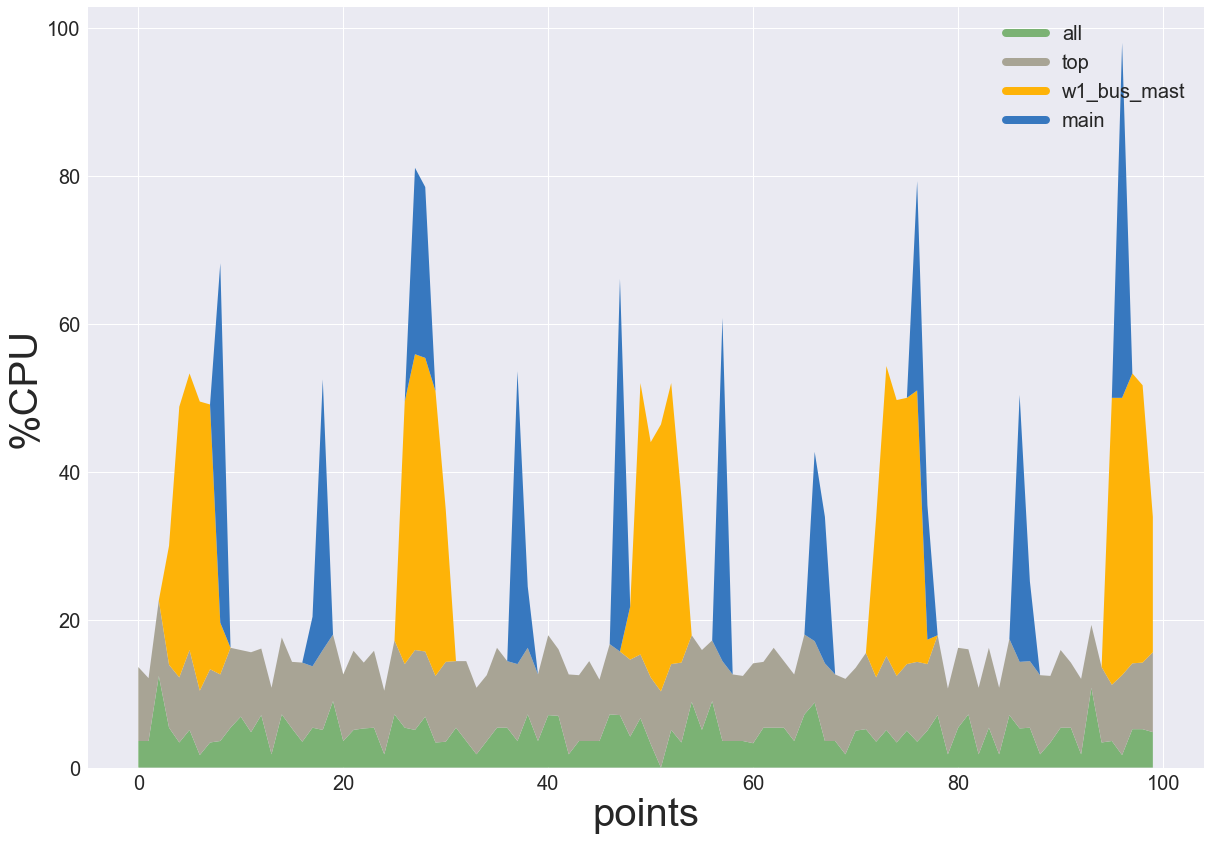

In [31]:
keys = ['722', '165', '945'] # 722 = top, w1 bus master, 945 = main

concise = prep_for_graph(cpu4, keys)

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',            linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',            linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_mast',    linewidth = 8)
ax.plot([], [], color = C[3], label = 'main',           linewidth = 8)

main4 = concise['945']

ax.stackplot(points, concise['all'][0:100], concise['722'][0:100],
             concise['165'][0:100], concise['945'][0:100], colors = C)



ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',            linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',            linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_mast',    linewidth = 8)
ax.plot([], [], color = C[3], label = 'main',           linewidth = 8)

ax.stackplot(points, concise['all'][100:200], concise['722'][100:200],
             concise['165'][100:200], concise['945'][100:200], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

Key: 721	Mean 32.6194444444
Key: 862	Mean 23.2666666667
Key: 868	Mean 19.5
Key: 900	Mean 19.5
Key: 1378	Mean 18.2
Key: 847	Mean 12.94
Key: 732	Mean 8.97651648137
Key: 165	Mean 7.50271160178
Key: 1422	Mean 5.5
Key: 1519	Mean 5.5


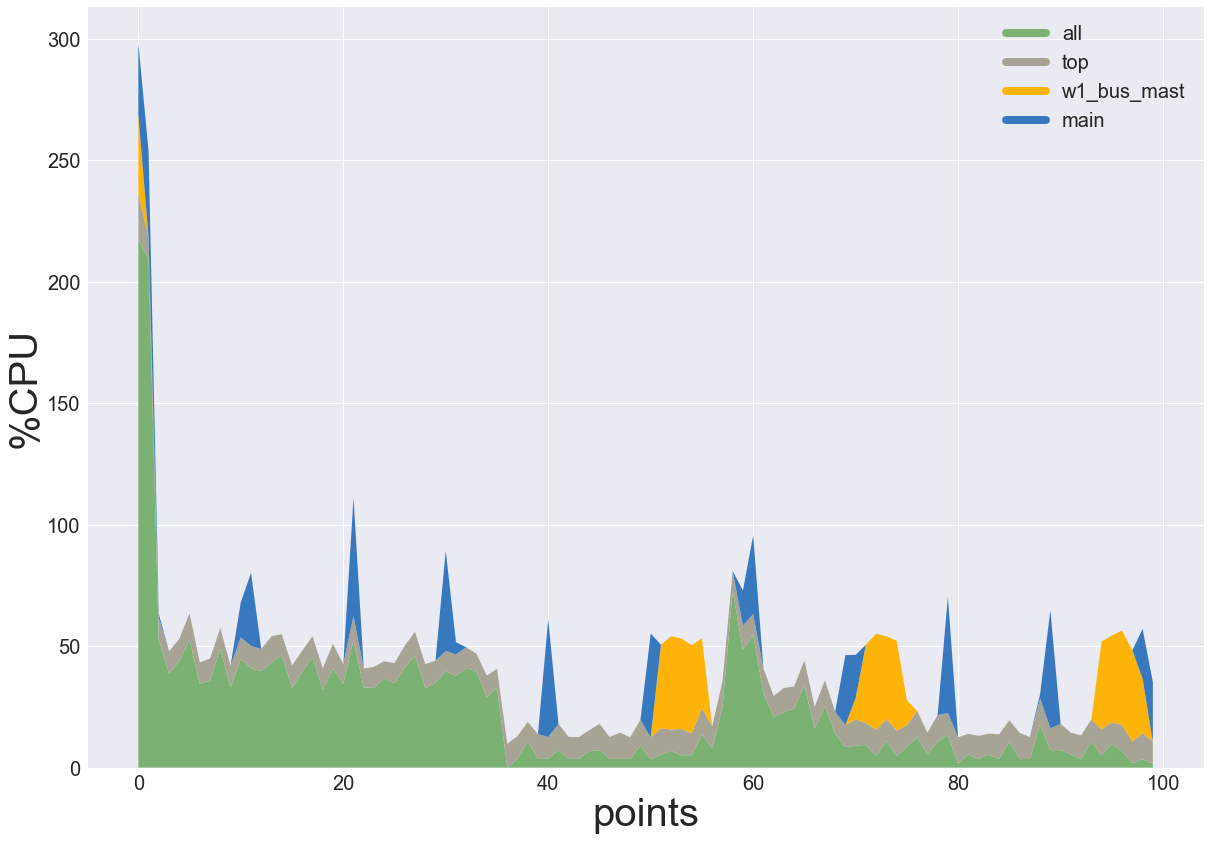

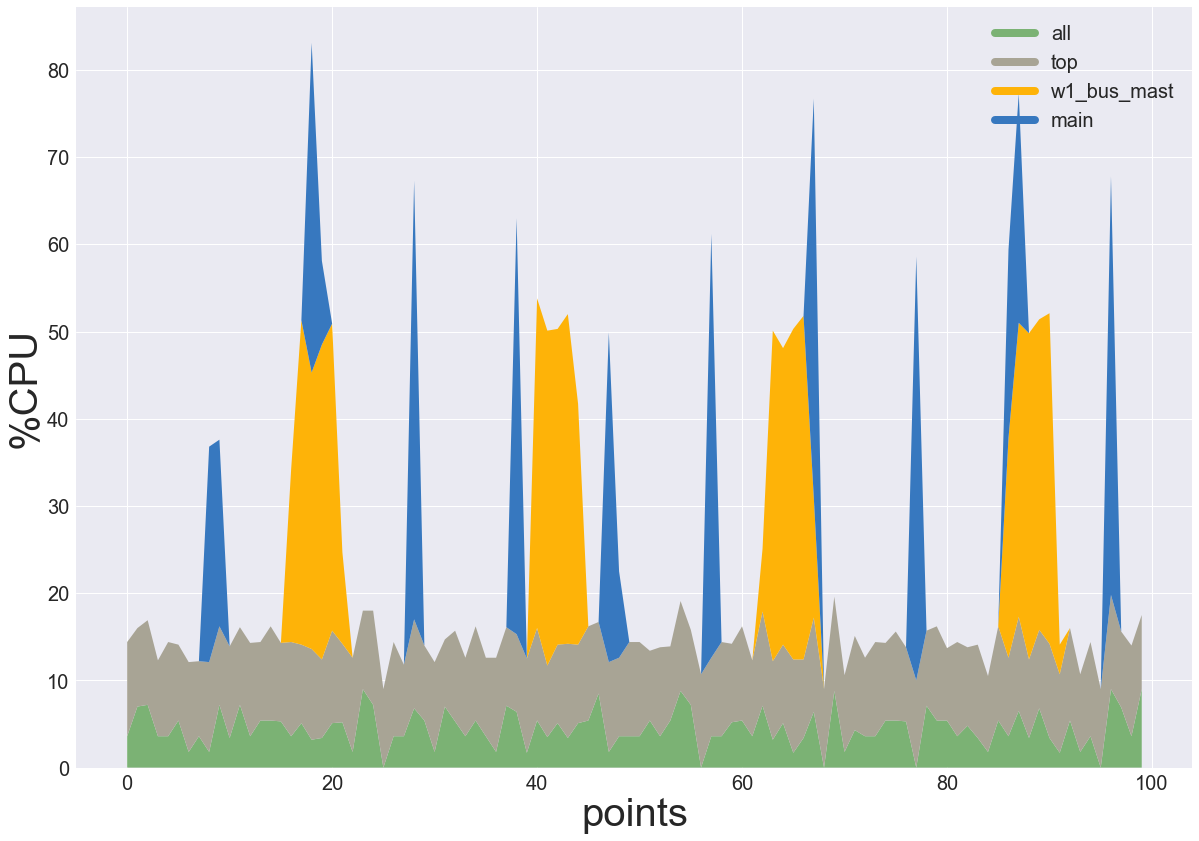

In [32]:
sortedCPU = ave(cpu5)

i = 0
for k in sortedCPU:
    if i == 10:
        break
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedCPU[k]))

keys = ['732', '165', '962'] # 732 = top, w1 bus master, 945 = main

concise = prep_for_graph(cpu5, keys)

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',            linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',            linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_mast',    linewidth = 8)
ax.plot([], [], color = C[3], label = 'main',           linewidth = 8)


main5 = concise['962']
ax.stackplot(points, concise['all'][0:100], concise['732'][0:100],
             concise['165'][0:100], concise['962'][0:100], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',            linewidth = 8)
ax.plot([], [], color = C[1], label = 'top',            linewidth = 8)
ax.plot([], [], color = C[2], label = 'w1_bus_mast',    linewidth = 8)
ax.plot([], [], color = C[3], label = 'main',           linewidth = 8)

ax.stackplot(points, concise['all'][100:200], concise['732'][100:200],
             concise['165'][100:200], concise['962'][100:200], colors = C)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

Now, time to deal with memory

In [33]:
sortedMEM = ave(mem)

i = 0
for k in sortedMEM:
    if i == 10:
        break
        
    i += 1
    print("Key: " + str(k) + "\tMean " + str(sortedMEM[k]))

Key: 506	Mean 7.42080076951
Key: 12975	Mean 5.36666666667
Key: 12980	Mean 4.4
Key: 12858	Mean 3.89998791541
Key: 497	Mean 2.7
Key: 645	Mean 1.9
Key: 13058	Mean 1.4228339787
Key: 1165	Mean 1.4
Key: 1272	Mean 1.4
Key: 12919	Mean 1.32857142857


### Memory

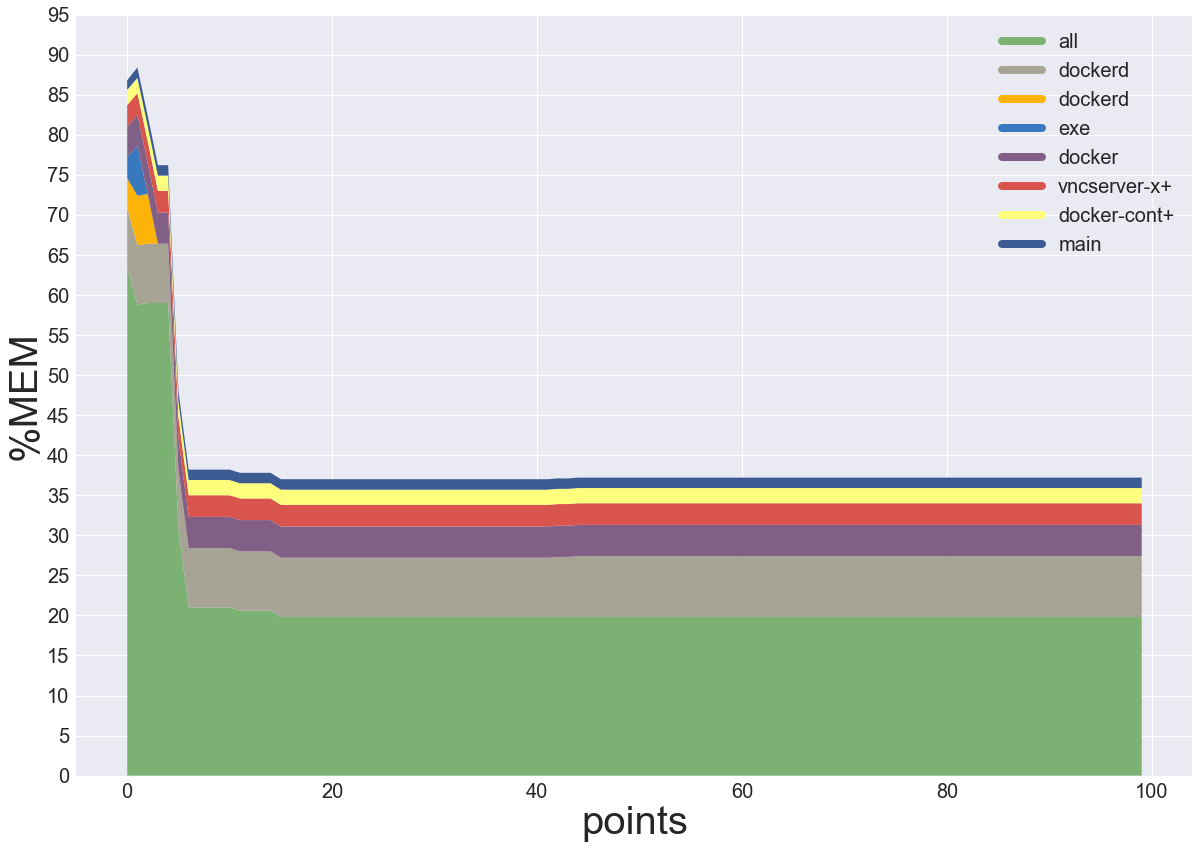

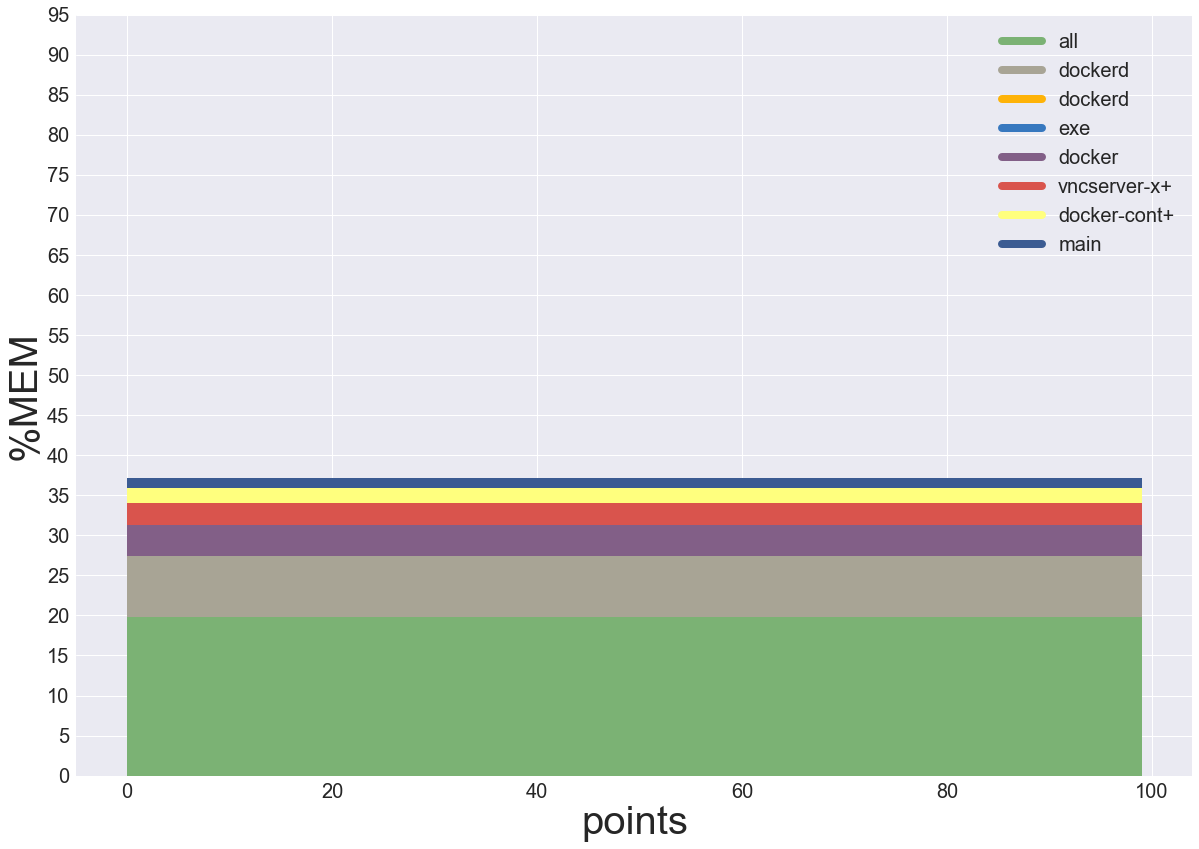

In [34]:
keys = ['506', '12975', '12980', '12858', '497', '645', '13058']
concise = prep_for_graph(mem, keys)

points = np.arange(0, 100)
C = ["#7bb274", "#a8a495", "#feb308", "#3778bf", "#825f87", '#d9544d', '#ffff7e', '#3b5b92']

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[2], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[3], label = 'exe',             linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker',          linewidth = 8)
ax.plot([], [], color = C[5], label = 'vncserver-x+',    linewidth = 8)
ax.plot([], [], color = C[6], label = 'docker-cont+',    linewidth = 8)
ax.plot([], [], color = C[7], label = 'main',            linewidth = 8)

ax.stackplot(points, concise['all'][0:100], concise['506'][0:100], concise['12975'][0:100],
             concise['12980'][0:100], concise['12858'][0:100], concise['497'][0:100], concise['645'][0:100], 
             concise['13058'][0:100], colors = C)

ax.set_ylabel('%MEM', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_yticks(np.arange(0, 100, 5))

ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Performance")

# Due to some bug with stackplot, a hack has to be used to get a legend up
ax.plot([], [], color = C[0], label = 'all',             linewidth = 8)
ax.plot([], [], color = C[1], label = 'dockerd',             linewidth = 8)
ax.plot([], [], color = C[2], label = 'dockerd',         linewidth = 8)
ax.plot([], [], color = C[3], label = 'exe',             linewidth = 8)
ax.plot([], [], color = C[4], label = 'docker',     linewidth = 8)
ax.plot([], [], color = C[5], label = 'vncserver-x+',     linewidth = 8)
ax.plot([], [], color = C[6], label = 'docker-cont+',            linewidth = 8)
ax.plot([], [], color = C[7], label = 'main',            linewidth = 8)

ax.stackplot(points, concise['all'][100:200], concise['506'][100:200], concise['12975'][100:200],
             concise['12980'][100:200], concise['12858'][100:200], concise['497'][100:200], concise['645'][100:200], 
             concise['13058'][100:200], colors = C)

ax.set_ylabel('%MEM', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)
ax.set_yticks(np.arange(0, 100, 5))

ax.legend(prop = {'size': 20})

ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)

plt.show()



# Comparison of Programs

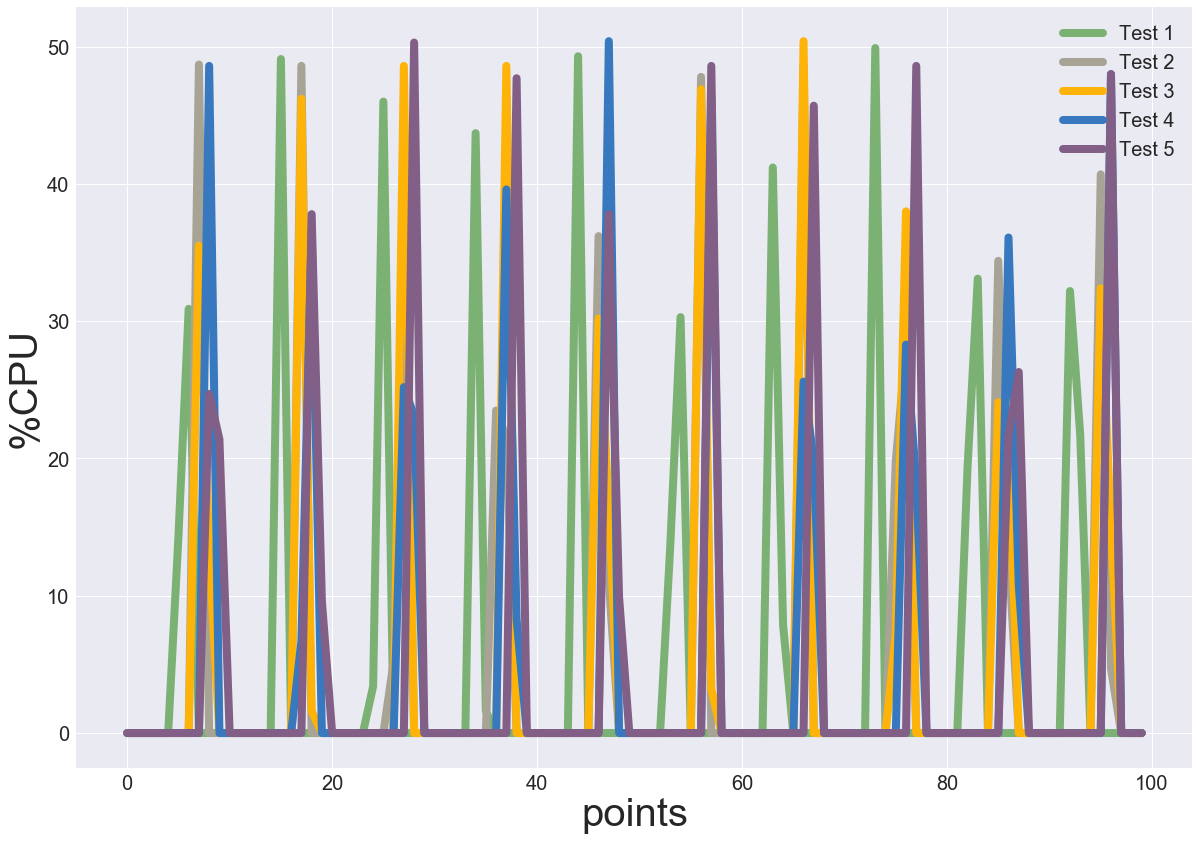

In [36]:
points = np.arange(0, 100)

fig = plt.figure(figsize = (20, 14))
ax = fig.add_subplot(111, label = "Comparison")
ax.plot(points, main1[100:200], color = C[0], label = 'Test 1', linewidth = 8)
ax.plot(points, main2[100:200], color = C[1], label = 'Test 2', linewidth = 8)
ax.plot(points, main3[100:200], color = C[2], label = 'Test 3', linewidth = 8)
ax.plot(points, main4[100:200], color = C[3], label = 'Test 4', linewidth = 8)
ax.plot(points, main5[100:200], color = C[4], label = 'Test 5', linewidth = 8)

ax.set_ylabel('%CPU', fontsize = 40)
ax.set_xlabel('points', fontsize = 40)

ax.legend(prop = {'size': 20})
ax.tick_params(axis = 'both', which = 'major', labelsize = 20)
ax.tick_params(axis = 'both', which = 'minor', labelsize = 20)
plt.show()

In [46]:
main1Average = sum(main1)/len(main1)
main2Average = sum(main2)/len(main2)
main3Average = sum(main3)/len(main3)
main4Average = sum(main4)/len(main4)
main5Average = sum(main5)/len(main5)


print("Test 1 Average:\t" + str(main1Average))
print("Test 2 Average:\t" + str(main2Average))
print("Test 3 Average:\t" + str(main3Average))
print("Test 4 Average:\t" + str(main4Average))
print("Test 5 Average:\t" + str(main5Average))

print("\n\n")

print("Test 1 std:\t" + str(np.std(main1)))
print("Test 2 std:\t" + str(np.std(main2)))
print("Test 3 std:\t" + str(np.std(main3)))
print("Test 4 std:\t" + str(np.std(main4)))
print("Test 5 std:\t" + str(np.std(main5)))

Test 1 Average:	4.747216544427077
Test 2 Average:	4.49217374290746
Test 3 Average:	4.659096657633233
Test 4 Average:	4.582652619425603
Test 5 Average:	4.539085802827811



Test 1 std:	12.5570106817
Test 2 std:	12.1504644895
Test 3 std:	12.3415267553
Test 4 std:	12.2328809512
Test 5 std:	12.2178680278
